In [4]:
from preprocessing_last20 import *
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
from d2c_encoder import D2CEncoder
from d2c_decoder import D2CDecoder
device = torch.device('cuda:3')
train_data = train_data.to(device)
test_data = test_data.to(device)

In [5]:
ddpm = DDPM(eps_model=NaiveUnet(16, 16, n_feat=128), betas=(1e-4, 0.02), n_T=200).to(device)
encoder = D2CEncoder().to(device)
decoder = D2CDecoder().to(device)
MSE = nn.MSELoss()

In [6]:
def train_1_ep_d2c(num_epoch, optim_e, optim_g, optim_d, alpha):

    print(f"Epoch {num_epoch} : ")
    ddpm.train()
    encoder.train()
    decoder.train()
    
    # batch of size 4
    train_data_tmp = train_data[torch.randperm(train_data.size()[0])]
    train_data_tmp = train_data_tmp.reshape(50, 4, 1, 64, 64)
    
    for i in tqdm(range(train_data_tmp.shape[0])):
        optim_e.zero_grad()
        optim_g.zero_grad()
        optim_d.zero_grad()
        z = encoder(train_data_tmp[i])
        l_d, denoised_z = ddpm.forward(z, True)
        l_e = MSE(z, denoised_z)
        l_g = MSE(train_data_tmp[i], decoder(denoised_z))
        loss = l_d+l_e+l_g*alpha
        loss.backward()

        optim_e.step()
        optim_g.step()
        optim_d.step()
    print('loss: ',loss.item(), " l_d: ", l_d.item(), " l_e: ", l_e.item(), " l_g: ", l_g.item())
    if num_epoch%20 == 0:
        ddpm.eval()
        with torch.no_grad():
            xh = decoder(ddpm.sample(1, (16, 32, 32), device))
            tensor_to_picture(xh.detach().cpu().numpy()[0][0])

    # save model
    torch.save(ddpm.state_dict(), f"./d2c.pth")

In [7]:
def test_d2c(encoder, decoder, diffusion):  
#     gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    encoder.eval()
    decoder.eval()
    diffusion.eval()
    tensor_to_picture(decoder(encoder(test_data[0])).detach().cpu().numpy()[0][0])

In [8]:
def train_d2c(epoch, lr, lr_decay, reg, alpha):
    for i in range(epoch):
        
        optim_e = torch.optim.SGD(encoder.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        optim_g = torch.optim.SGD(decoder.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        optim_d = torch.optim.SGD(ddpm.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        train_1_ep_d2c(i, optim_e, optim_g, optim_d, alpha)
        if i%10==0:
            test_d2c(encoder, decoder, ddpm)

Epoch 0 : 


100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


loss:  4.871645927429199  l_d:  1.0990865230560303  l_e:  1.0990865230560303  l_g:  0.2673473060131073


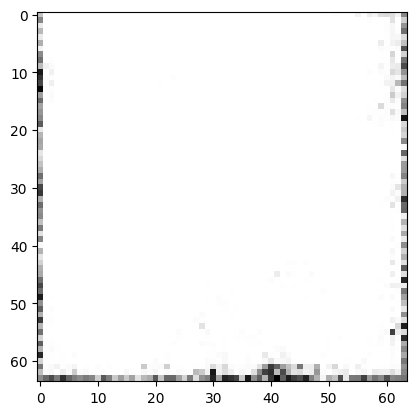

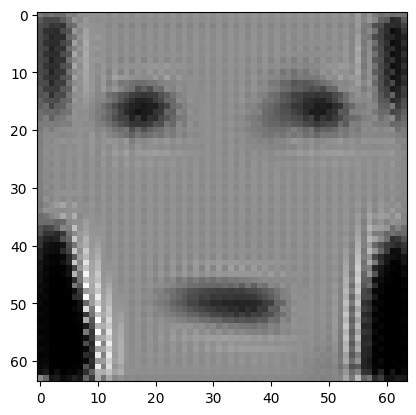

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  4.6611528396606445  l_d:  0.8822693228721619  l_e:  0.8822693228721619  l_g:  0.2896614074707031
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 15.50it/s]


loss:  3.514594316482544  l_d:  0.901932954788208  l_e:  0.901932954788208  l_g:  0.1710728406906128
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


loss:  3.445012331008911  l_d:  0.7194787263870239  l_e:  0.7194787263870239  l_g:  0.20060548186302185
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


loss:  3.509312868118286  l_d:  0.6447380781173706  l_e:  0.6447380185127258  l_g:  0.2219836711883545
Epoch 5 : 


100%|██████████| 50/50 [00:04<00:00, 11.78it/s]


loss:  3.7654054164886475  l_d:  0.6767185926437378  l_e:  0.6767185926437378  l_g:  0.24119681119918823
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 14.25it/s]


loss:  3.0398240089416504  l_d:  0.6159956455230713  l_e:  0.6159956455230713  l_g:  0.18078328669071198
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 15.91it/s]


loss:  3.0150668621063232  l_d:  0.446574330329895  l_e:  0.446574330329895  l_g:  0.21219182014465332
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  2.7409567832946777  l_d:  0.6575322151184082  l_e:  0.6575322151184082  l_g:  0.1425892412662506
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  2.687227249145508  l_d:  0.4500366449356079  l_e:  0.4500366449356079  l_g:  0.17871540784835815
Epoch 10 : 


100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


loss:  2.3464150428771973  l_d:  0.4077152907848358  l_e:  0.4077152609825134  l_g:  0.1530984342098236


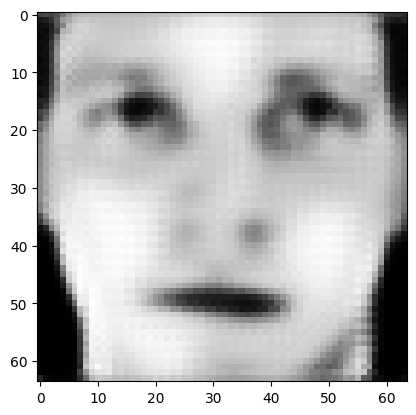

Epoch 11 : 


100%|██████████| 50/50 [00:04<00:00, 12.43it/s]


loss:  2.40876841545105  l_d:  0.3988912105560303  l_e:  0.3988912105560303  l_g:  0.16109859943389893
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


loss:  1.5974087715148926  l_d:  0.2303452491760254  l_e:  0.2303452491760254  l_g:  0.11367182433605194
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


loss:  2.5833332538604736  l_d:  0.23278912901878357  l_e:  0.23278912901878357  l_g:  0.21177548170089722
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


loss:  3.0461268424987793  l_d:  0.5166174173355103  l_e:  0.5166174173355103  l_g:  0.20128920674324036
Epoch 15 : 


100%|██████████| 50/50 [00:04<00:00, 11.56it/s]


loss:  2.15303635597229  l_d:  0.19061076641082764  l_e:  0.19061076641082764  l_g:  0.17718148231506348
Epoch 16 : 


100%|██████████| 50/50 [00:04<00:00, 11.76it/s]


loss:  1.9439185857772827  l_d:  0.18967270851135254  l_e:  0.18967270851135254  l_g:  0.15645731985569
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 12.79it/s]


loss:  2.447293758392334  l_d:  0.21865040063858032  l_e:  0.21865040063858032  l_g:  0.20099931955337524
Epoch 18 : 


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


loss:  1.9775526523590088  l_d:  0.4093989133834839  l_e:  0.4093989133834839  l_g:  0.1158754825592041
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 12.55it/s]


loss:  2.2964529991149902  l_d:  0.36058610677719116  l_e:  0.36058610677719116  l_g:  0.1575280874967575
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.734310507774353  l_d:  0.1521504670381546  l_e:  0.1521504670381546  l_g:  0.14300096035003662


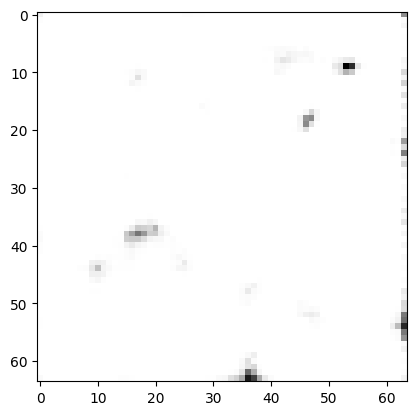

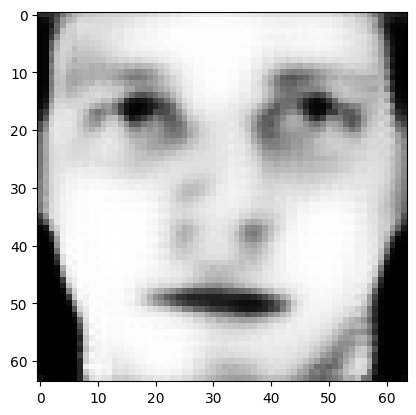

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  2.332925796508789  l_d:  0.23291915655136108  l_e:  0.23291915655136108  l_g:  0.1867087334394455
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 15.67it/s]


loss:  2.5643978118896484  l_d:  0.2548372745513916  l_e:  0.2548372745513916  l_g:  0.20547232031822205
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


loss:  1.7144520282745361  l_d:  0.15462329983711243  l_e:  0.15462329983711243  l_g:  0.14052054286003113
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  2.2115721702575684  l_d:  0.27672094106674194  l_e:  0.27672094106674194  l_g:  0.16581301391124725
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


loss:  1.343559741973877  l_d:  0.15728619694709778  l_e:  0.15728619694709778  l_g:  0.1028987392783165
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  2.236921548843384  l_d:  0.30945026874542236  l_e:  0.30945026874542236  l_g:  0.16180209815502167
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  2.0694892406463623  l_d:  0.20643839240074158  l_e:  0.20643839240074158  l_g:  0.16566124558448792
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


loss:  1.5228564739227295  l_d:  0.13689160346984863  l_e:  0.13689160346984863  l_g:  0.12490732222795486
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


loss:  2.3356127738952637  l_d:  0.4188290238380432  l_e:  0.4188290536403656  l_g:  0.14979545772075653
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  1.9250272512435913  l_d:  0.2504599690437317  l_e:  0.2504599690437317  l_g:  0.14241072535514832


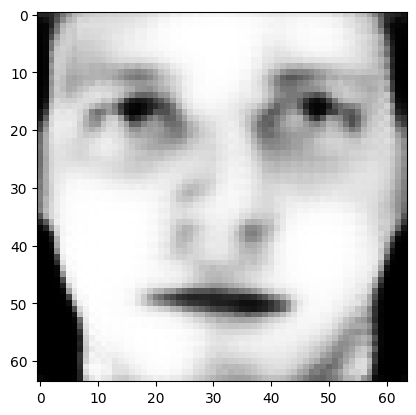

Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  2.1859991550445557  l_d:  0.13798683881759644  l_e:  0.13798683881759644  l_g:  0.19100254774093628
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


loss:  2.3365912437438965  l_d:  0.14256513118743896  l_e:  0.14256513118743896  l_g:  0.20514610409736633
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


loss:  1.3797558546066284  l_d:  0.13052332401275635  l_e:  0.13052332401275635  l_g:  0.11187092214822769
Epoch 34 : 


100%|██████████| 50/50 [00:04<00:00, 12.36it/s]


loss:  2.143479108810425  l_d:  0.36265313625335693  l_e:  0.36265313625335693  l_g:  0.14181728661060333
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


loss:  1.8429149389266968  l_d:  0.13270634412765503  l_e:  0.13270634412765503  l_g:  0.1577502191066742
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


loss:  2.794900417327881  l_d:  0.3666762709617615  l_e:  0.3666762709617615  l_g:  0.20615476369857788
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  2.322401523590088  l_d:  0.30763739347457886  l_e:  0.30763739347457886  l_g:  0.1707126796245575
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


loss:  2.123560667037964  l_d:  0.2488829493522644  l_e:  0.2488829493522644  l_g:  0.1625794768333435
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


loss:  1.0529905557632446  l_d:  0.13971351087093353  l_e:  0.13971351087093353  l_g:  0.07735635340213776
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 15.31it/s]


loss:  2.1518805027008057  l_d:  0.12385229766368866  l_e:  0.12385229021310806  l_g:  0.1904176026582718


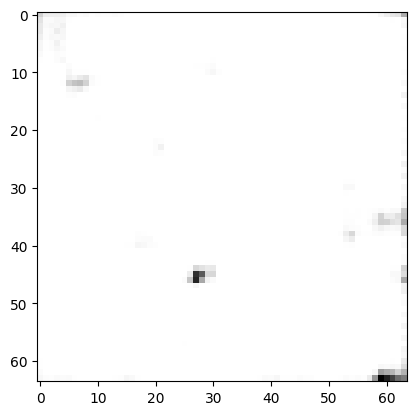

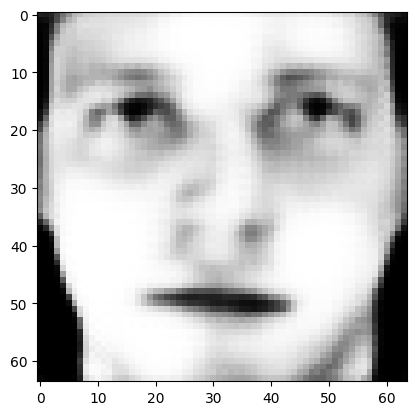

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


loss:  1.8271465301513672  l_d:  0.13960781693458557  l_e:  0.13960780203342438  l_g:  0.15479309856891632
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  2.4532113075256348  l_d:  0.29835575819015503  l_e:  0.29835575819015503  l_g:  0.18564996123313904
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


loss:  1.9141007661819458  l_d:  0.12821441888809204  l_e:  0.12821441888809204  l_g:  0.16576719284057617
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 15.67it/s]


loss:  1.387695074081421  l_d:  0.1380254030227661  l_e:  0.13802538812160492  l_g:  0.11116442829370499
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


loss:  1.7484428882598877  l_d:  0.12431186437606812  l_e:  0.12431186437606812  l_g:  0.14998191595077515
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


loss:  1.6025316715240479  l_d:  0.16136035323143005  l_e:  0.16136035323143005  l_g:  0.12798109650611877
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


loss:  1.7762017250061035  l_d:  0.13171051442623138  l_e:  0.13171051442623138  l_g:  0.1512780636548996
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 14.80it/s]


loss:  2.1319684982299805  l_d:  0.130658358335495  l_e:  0.130658358335495  l_g:  0.18706518411636353
Epoch 49 : 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


loss:  1.5947890281677246  l_d:  0.1304980218410492  l_e:  0.1304980218410492  l_g:  0.13337929546833038
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  1.6327075958251953  l_d:  0.11575314402580261  l_e:  0.11575314402580261  l_g:  0.14012011885643005


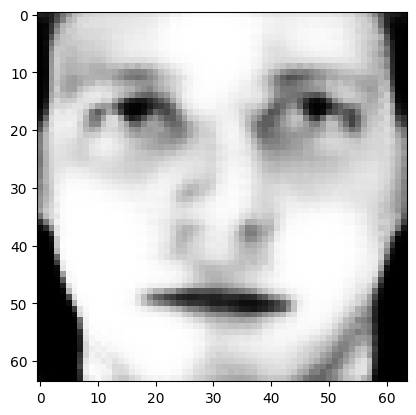

Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  2.458268404006958  l_d:  0.35646161437034607  l_e:  0.35646161437034607  l_g:  0.17453451454639435
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


loss:  1.610004186630249  l_d:  0.11616344004869461  l_e:  0.11616344749927521  l_g:  0.1377677321434021
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


loss:  1.8566040992736816  l_d:  0.18197786808013916  l_e:  0.18197786808013916  l_g:  0.1492648422718048
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


loss:  1.7818102836608887  l_d:  0.18793699145317078  l_e:  0.18793699145317078  l_g:  0.14059361815452576
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


loss:  1.9769678115844727  l_d:  0.27613869309425354  l_e:  0.27613866329193115  l_g:  0.14246904850006104
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


loss:  0.9583269357681274  l_d:  0.13412968814373016  l_e:  0.13412968814373016  l_g:  0.06900675594806671
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  2.4583487510681152  l_d:  0.11805099248886108  l_e:  0.11805099248886108  l_g:  0.2222246527671814
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


loss:  1.3443899154663086  l_d:  0.11668485403060913  l_e:  0.11668486148118973  l_g:  0.11110202223062515
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  1.7865597009658813  l_d:  0.12587730586528778  l_e:  0.12587730586528778  l_g:  0.15348049998283386
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 13.81it/s]


loss:  2.2868218421936035  l_d:  0.24918043613433838  l_e:  0.24918043613433838  l_g:  0.1788461059331894


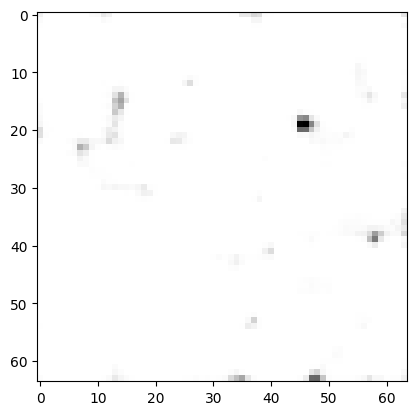

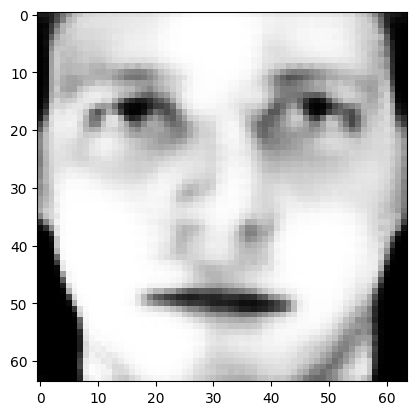

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


loss:  1.303438663482666  l_d:  0.15971232950687408  l_e:  0.1597123146057129  l_g:  0.09840139746665955
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


loss:  1.8375012874603271  l_d:  0.12581084668636322  l_e:  0.12581084668636322  l_g:  0.1585879623889923
Epoch 63 : 


100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


loss:  1.7199431657791138  l_d:  0.32559627294540405  l_e:  0.32559627294540405  l_g:  0.10687506198883057
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  2.5114381313323975  l_d:  0.26163971424102783  l_e:  0.26163971424102783  l_g:  0.19881586730480194
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


loss:  2.227644205093384  l_d:  0.16946254670619965  l_e:  0.16946253180503845  l_g:  0.18887190520763397
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.53it/s]


loss:  1.6665998697280884  l_d:  0.1355227380990982  l_e:  0.1355227380990982  l_g:  0.1395554393529892
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


loss:  2.056837320327759  l_d:  0.11982974410057068  l_e:  0.11982974410057068  l_g:  0.18171778321266174
Epoch 68 : 


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


loss:  1.8898556232452393  l_d:  0.12024852633476257  l_e:  0.12024852633476257  l_g:  0.1649358570575714
Epoch 69 : 


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


loss:  1.1615934371948242  l_d:  0.12762196362018585  l_e:  0.12762197852134705  l_g:  0.09063494950532913
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


loss:  2.1550521850585938  l_d:  0.25500622391700745  l_e:  0.25500619411468506  l_g:  0.16450397670269012


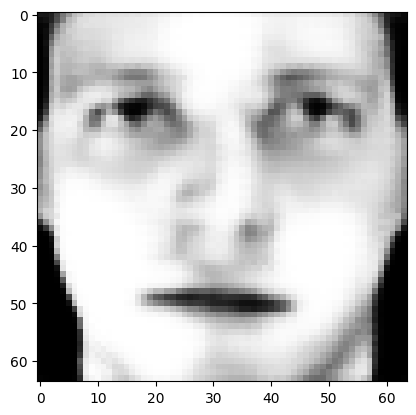

Epoch 71 : 


100%|██████████| 50/50 [00:04<00:00, 11.80it/s]


loss:  1.4264724254608154  l_d:  0.1787201166152954  l_e:  0.17872010171413422  l_g:  0.10690322518348694
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


loss:  1.7682554721832275  l_d:  0.11709526926279068  l_e:  0.11709526926279068  l_g:  0.15340648591518402
Epoch 73 : 


100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


loss:  1.6314347982406616  l_d:  0.11488525569438934  l_e:  0.11488525569438934  l_g:  0.14016643166542053
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


loss:  2.2306418418884277  l_d:  0.33998653292655945  l_e:  0.33998656272888184  l_g:  0.15506687760353088
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.5231212377548218  l_d:  0.12047881633043289  l_e:  0.1204788088798523  l_g:  0.12821635603904724
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


loss:  2.49418044090271  l_d:  0.11039935797452927  l_e:  0.11039935797452927  l_g:  0.22733816504478455
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


loss:  1.7392252683639526  l_d:  0.11354555189609528  l_e:  0.11354555934667587  l_g:  0.15121342241764069
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


loss:  1.4691396951675415  l_d:  0.11318595707416534  l_e:  0.11318595707416534  l_g:  0.1242767870426178
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


loss:  1.8701889514923096  l_d:  0.10832393169403076  l_e:  0.10832393169403076  l_g:  0.16535410284996033
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  1.9750885963439941  l_d:  0.11110933870077133  l_e:  0.11110934615135193  l_g:  0.17528699338436127


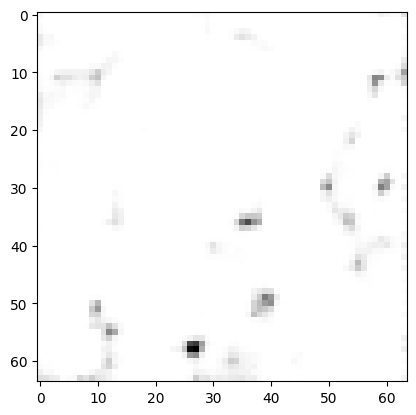

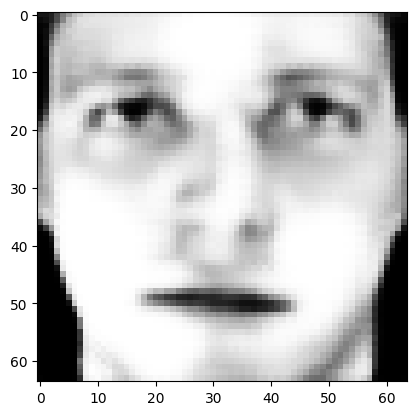

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  1.4763803482055664  l_d:  0.12886038422584534  l_e:  0.12886039912700653  l_g:  0.12186595797538757
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


loss:  1.8240065574645996  l_d:  0.10712586343288422  l_e:  0.10712586343288422  l_g:  0.16097548604011536
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


loss:  2.406548500061035  l_d:  0.27747493982315063  l_e:  0.27747493982315063  l_g:  0.1851598620414734
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 12.82it/s]


loss:  1.4829481840133667  l_d:  0.11846451461315155  l_e:  0.11846451461315155  l_g:  0.12460191547870636
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  1.5659691095352173  l_d:  0.17665213346481323  l_e:  0.17665214836597443  l_g:  0.12126648426055908
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  2.0187199115753174  l_d:  0.2834303081035614  l_e:  0.2834303081035614  l_g:  0.1451859176158905
Epoch 87 : 


100%|██████████| 50/50 [00:04<00:00, 12.15it/s]


loss:  1.3651366233825684  l_d:  0.15918944776058197  l_e:  0.15918944776058197  l_g:  0.1046757698059082
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


loss:  1.7948315143585205  l_d:  0.14097216725349426  l_e:  0.14097216725349426  l_g:  0.1512887179851532
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  1.481163501739502  l_d:  0.14738807082176208  l_e:  0.14738808572292328  l_g:  0.11863874644041061
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


loss:  1.5129938125610352  l_d:  0.10957519710063934  l_e:  0.10957520455121994  l_g:  0.1293843388557434


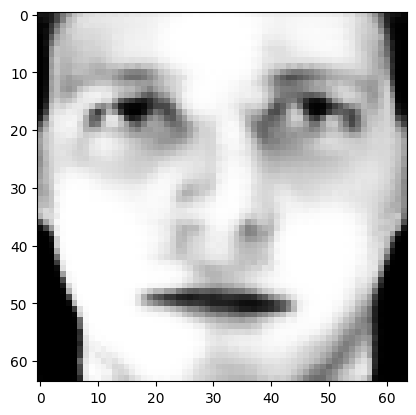

Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  2.4503660202026367  l_d:  0.25188785791397095  l_e:  0.25188785791397095  l_g:  0.194659024477005
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 15.29it/s]


loss:  1.7534277439117432  l_d:  0.11909062415361404  l_e:  0.11909062415361404  l_g:  0.1515246480703354
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 14.93it/s]


loss:  2.3792591094970703  l_d:  0.1451379656791687  l_e:  0.1451379656791687  l_g:  0.20889833569526672
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  1.5613795518875122  l_d:  0.10915352404117584  l_e:  0.10915352404117584  l_g:  0.13430725038051605
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


loss:  1.5262067317962646  l_d:  0.16130155324935913  l_e:  0.16130155324935913  l_g:  0.1203603595495224
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


loss:  2.4969711303710938  l_d:  0.13679388165473938  l_e:  0.13679386675357819  l_g:  0.22233834862709045
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 14.78it/s]


loss:  1.6362824440002441  l_d:  0.21365153789520264  l_e:  0.21365153789520264  l_g:  0.12089793384075165
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  1.6369699239730835  l_d:  0.12803369760513306  l_e:  0.12803369760513306  l_g:  0.13809025287628174
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


loss:  1.954758644104004  l_d:  0.30041664838790894  l_e:  0.3004166781902313  l_g:  0.13539253175258636


In [9]:
train_d2c(100, 0.001, 1, 0.00001, 10)

Epoch 0 : 


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


loss:  2.394534111022949  l_d:  0.35639533400535583  l_e:  0.35639533400535583  l_g:  0.16817434132099152


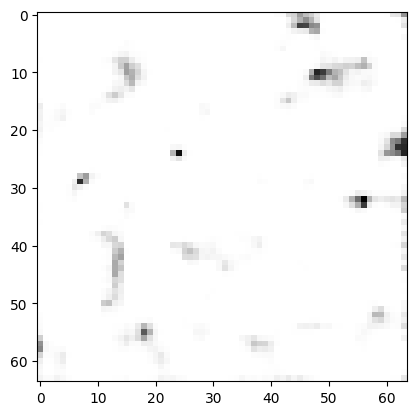

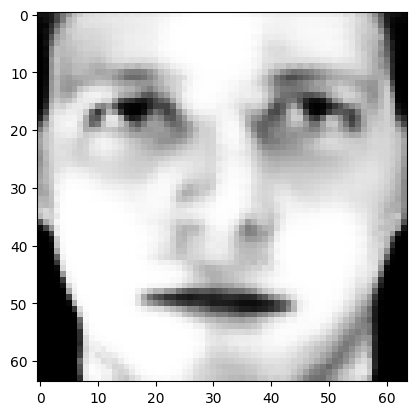

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


loss:  2.1477162837982178  l_d:  0.18126367032527924  l_e:  0.18126367032527924  l_g:  0.1785188913345337
Epoch 2 : 


100%|██████████| 50/50 [00:04<00:00, 12.14it/s]


loss:  2.4900412559509277  l_d:  0.3369513154029846  l_e:  0.3369513154029846  l_g:  0.18161386251449585
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


loss:  1.6050385236740112  l_d:  0.11875669658184052  l_e:  0.11875669658184052  l_g:  0.13675251603126526
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 12.75it/s]


loss:  2.011284351348877  l_d:  0.1313232034444809  l_e:  0.1313232183456421  l_g:  0.1748637855052948
Epoch 5 : 


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


loss:  2.0880422592163086  l_d:  0.11744076013565063  l_e:  0.11744076013565063  l_g:  0.1853160560131073
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


loss:  1.5825697183609009  l_d:  0.10884179174900055  l_e:  0.10884179174900055  l_g:  0.13648861646652222
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


loss:  1.5966747999191284  l_d:  0.12195909023284912  l_e:  0.12195909023284912  l_g:  0.13527566194534302
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


loss:  1.5735182762145996  l_d:  0.11047419905662537  l_e:  0.11047420650720596  l_g:  0.13525697588920593
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


loss:  1.5373587608337402  l_d:  0.1280444860458374  l_e:  0.1280444860458374  l_g:  0.12812697887420654
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


loss:  1.579260230064392  l_d:  0.12140728533267975  l_e:  0.12140727788209915  l_g:  0.13364456593990326


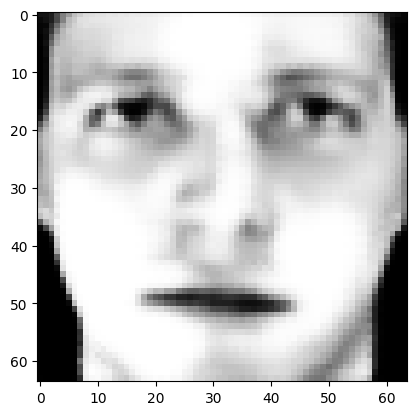

Epoch 11 : 


100%|██████████| 50/50 [00:04<00:00, 11.88it/s]


loss:  1.8871188163757324  l_d:  0.13347259163856506  l_e:  0.13347259163856506  l_g:  0.16201737523078918
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


loss:  2.276118755340576  l_d:  0.18540199100971222  l_e:  0.18540199100971222  l_g:  0.19053146243095398
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


loss:  1.5606008768081665  l_d:  0.10695929825305939  l_e:  0.10695929825305939  l_g:  0.134668231010437
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


loss:  2.016498565673828  l_d:  0.19013762474060059  l_e:  0.19013762474060059  l_g:  0.16362231969833374
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


loss:  1.9895799160003662  l_d:  0.30405324697494507  l_e:  0.30405324697494507  l_g:  0.13814733922481537
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


loss:  1.9687085151672363  l_d:  0.10525131970643997  l_e:  0.10525131970643997  l_g:  0.17582058906555176
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


loss:  1.4729866981506348  l_d:  0.10785938799381256  l_e:  0.10785938799381256  l_g:  0.12572678923606873
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


loss:  1.3778446912765503  l_d:  0.11161953955888748  l_e:  0.11161953210830688  l_g:  0.11546055972576141
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 16.06it/s]


loss:  1.9485363960266113  l_d:  0.28026458621025085  l_e:  0.28026458621025085  l_g:  0.1388007253408432
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


loss:  2.5669021606445312  l_d:  0.1613655388355255  l_e:  0.1613655388355255  l_g:  0.22441712021827698


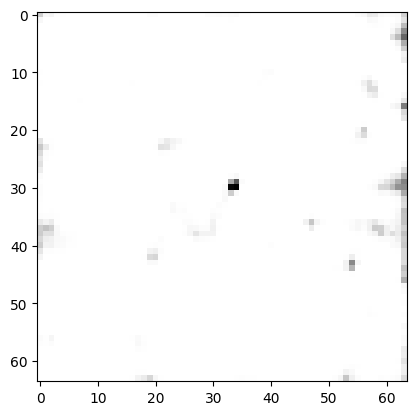

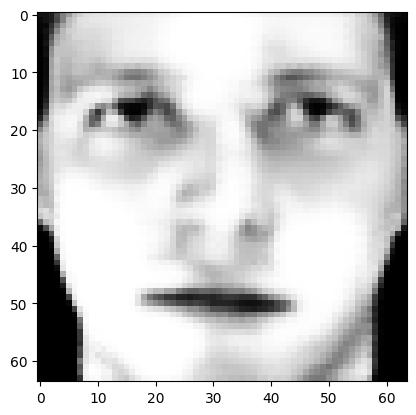

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 15.33it/s]


loss:  2.1331162452697754  l_d:  0.20353519916534424  l_e:  0.20353519916534424  l_g:  0.17260459065437317
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 14.47it/s]


loss:  1.3112380504608154  l_d:  0.15451009571552277  l_e:  0.15451009571552277  l_g:  0.10022179037332535
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


loss:  2.1359951496124268  l_d:  0.2553759217262268  l_e:  0.2553759217262268  l_g:  0.16252432763576508
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


loss:  1.1509884595870972  l_d:  0.1097097247838974  l_e:  0.1097097247838974  l_g:  0.09315690398216248
Epoch 25 : 


100%|██████████| 50/50 [00:04<00:00, 12.00it/s]


loss:  1.4526567459106445  l_d:  0.12007993459701538  l_e:  0.12007993459701538  l_g:  0.12124969065189362
Epoch 26 : 


100%|██████████| 50/50 [00:04<00:00, 11.62it/s]


loss:  1.4427735805511475  l_d:  0.11471974849700928  l_e:  0.11471974849700928  l_g:  0.12133340537548065
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


loss:  2.335157871246338  l_d:  0.27484071254730225  l_e:  0.27484068274497986  l_g:  0.17854763567447662
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  1.4479221105575562  l_d:  0.11079126596450806  l_e:  0.11079126596450806  l_g:  0.12263396382331848
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


loss:  1.7132911682128906  l_d:  0.14876121282577515  l_e:  0.14876121282577515  l_g:  0.1415768712759018
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 15.72it/s]


loss:  1.673585295677185  l_d:  0.10190129280090332  l_e:  0.10190129280090332  l_g:  0.14697827398777008


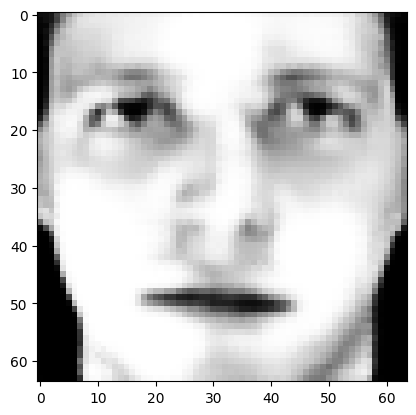

Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  2.1082446575164795  l_d:  0.16797837615013123  l_e:  0.16797837615013123  l_g:  0.17722877860069275
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


loss:  1.8008075952529907  l_d:  0.1107257679104805  l_e:  0.1107257679104805  l_g:  0.15793560445308685
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


loss:  1.9487183094024658  l_d:  0.10536924004554749  l_e:  0.10536924004554749  l_g:  0.17379799485206604
Epoch 34 : 


100%|██████████| 50/50 [00:04<00:00, 12.33it/s]


loss:  1.740452766418457  l_d:  0.11178026348352432  l_e:  0.11178026348352432  l_g:  0.15168921649456024
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


loss:  1.7378439903259277  l_d:  0.14694873988628387  l_e:  0.14694875478744507  l_g:  0.144394651055336
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 14.53it/s]


loss:  1.6665594577789307  l_d:  0.18997249007225037  l_e:  0.18997249007225037  l_g:  0.12866143882274628
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


loss:  1.3271205425262451  l_d:  0.10732480883598328  l_e:  0.10732480883598328  l_g:  0.11124709993600845
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


loss:  1.431307077407837  l_d:  0.1019795835018158  l_e:  0.1019795835018158  l_g:  0.12273479998111725
Epoch 39 : 


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


loss:  1.3518383502960205  l_d:  0.12712904810905457  l_e:  0.12712904810905457  l_g:  0.10975801944732666
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


loss:  2.4401333332061768  l_d:  0.1080949604511261  l_e:  0.1080949530005455  l_g:  0.22239434719085693


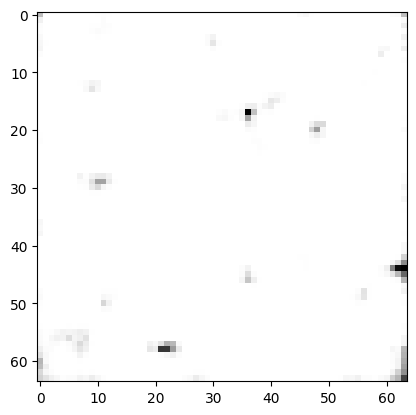

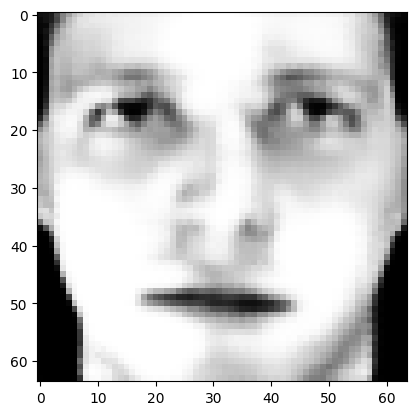

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


loss:  1.3231791257858276  l_d:  0.1209753155708313  l_e:  0.1209753155708313  l_g:  0.10812285542488098
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


loss:  1.6201850175857544  l_d:  0.11894924938678741  l_e:  0.11894924938678741  l_g:  0.1382286548614502
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


loss:  1.6074129343032837  l_d:  0.2142816185951233  l_e:  0.2142816185951233  l_g:  0.11788497120141983
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 15.38it/s]


loss:  1.9770922660827637  l_d:  0.1645265817642212  l_e:  0.1645265817642212  l_g:  0.1648039072751999
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


loss:  2.8378548622131348  l_d:  0.239763081073761  l_e:  0.239763081073761  l_g:  0.23583285510540009
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  1.1503015756607056  l_d:  0.1052120104432106  l_e:  0.1052120104432106  l_g:  0.09398774802684784
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


loss:  1.6651651859283447  l_d:  0.11772465705871582  l_e:  0.11772466450929642  l_g:  0.14297159016132355
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


loss:  1.38297438621521  l_d:  0.11846789717674255  l_e:  0.11846789717674255  l_g:  0.11460384726524353
Epoch 49 : 


100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


loss:  1.8845810890197754  l_d:  0.16145610809326172  l_e:  0.16145610809326172  l_g:  0.15616688132286072
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


loss:  1.768540620803833  l_d:  0.18002203106880188  l_e:  0.18002201616764069  l_g:  0.14084964990615845


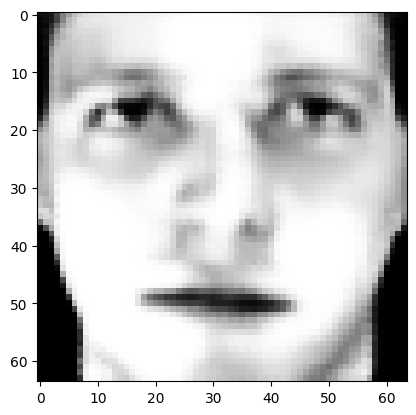

Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 13.84it/s]


loss:  2.129058837890625  l_d:  0.11710526794195175  l_e:  0.11710526794195175  l_g:  0.1894848346710205
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


loss:  2.064932107925415  l_d:  0.10050040483474731  l_e:  0.10050040483474731  l_g:  0.1863931268453598
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


loss:  1.7768386602401733  l_d:  0.10290223360061646  l_e:  0.10290223360061646  l_g:  0.15710341930389404
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


loss:  1.3057512044906616  l_d:  0.10019497573375702  l_e:  0.10019497573375702  l_g:  0.110536128282547
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]


loss:  1.5843098163604736  l_d:  0.13393080234527588  l_e:  0.13393080234527588  l_g:  0.1316448152065277
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


loss:  1.2338896989822388  l_d:  0.0997278243303299  l_e:  0.0997278168797493  l_g:  0.10344340652227402
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  1.9610944986343384  l_d:  0.13203446567058563  l_e:  0.13203446567058563  l_g:  0.16970255970954895
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 16.15it/s]


loss:  1.119307041168213  l_d:  0.09975776821374893  l_e:  0.09975776821374893  l_g:  0.09197914600372314
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.53it/s]


loss:  1.5741900205612183  l_d:  0.10517747700214386  l_e:  0.10517747700214386  l_g:  0.13638350367546082
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  2.2377448081970215  l_d:  0.2280767261981964  l_e:  0.2280767560005188  l_g:  0.17815914750099182


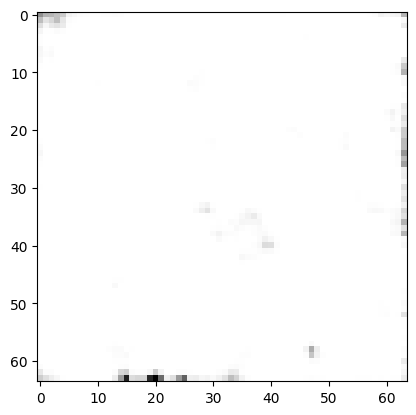

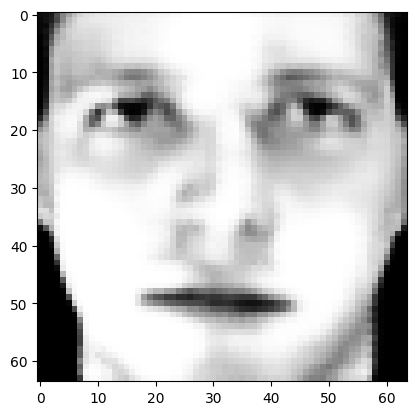

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 13.28it/s]


loss:  1.9991731643676758  l_d:  0.10027936100959778  l_e:  0.10027936100959778  l_g:  0.17986145615577698
Epoch 62 : 


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


loss:  1.0419588088989258  l_d:  0.10634763538837433  l_e:  0.10634763538837433  l_g:  0.08292635530233383
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  1.5647426843643188  l_d:  0.11033066362142563  l_e:  0.11033065617084503  l_g:  0.1344081461429596
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


loss:  1.7410255670547485  l_d:  0.11674797534942627  l_e:  0.11674797534942627  l_g:  0.1507529616355896
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 15.87it/s]


loss:  1.363541603088379  l_d:  0.10494628548622131  l_e:  0.10494628548622131  l_g:  0.11536489427089691
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


loss:  1.838136076927185  l_d:  0.12557631731033325  l_e:  0.12557631731033325  l_g:  0.15869835019111633
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


loss:  1.7736363410949707  l_d:  0.21316257119178772  l_e:  0.21316257119178772  l_g:  0.13473111391067505
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


loss:  2.5259852409362793  l_d:  0.14532452821731567  l_e:  0.14532452821731567  l_g:  0.22353361546993256
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


loss:  1.7367169857025146  l_d:  0.10801324248313904  l_e:  0.10801324248313904  l_g:  0.15206904709339142
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


loss:  1.73284113407135  l_d:  0.20841078460216522  l_e:  0.20841078460216522  l_g:  0.1316019594669342


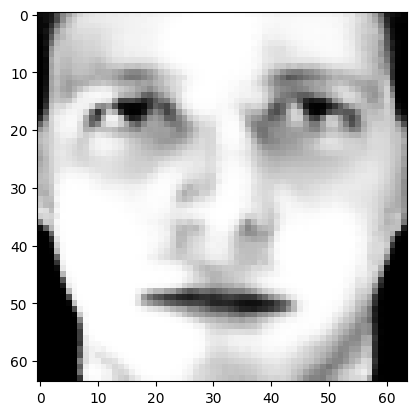

Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


loss:  1.828242540359497  l_d:  0.11871757358312607  l_e:  0.11871756613254547  l_g:  0.15908074378967285
Epoch 72 : 


100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


loss:  1.8131182193756104  l_d:  0.10215987265110016  l_e:  0.10215987265110016  l_g:  0.16087985038757324
Epoch 73 : 


100%|██████████| 50/50 [00:03<00:00, 16.33it/s]


loss:  1.8075830936431885  l_d:  0.11578584462404251  l_e:  0.11578585207462311  l_g:  0.15760114789009094
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


loss:  1.4617316722869873  l_d:  0.09852367639541626  l_e:  0.09852367639541626  l_g:  0.12646843492984772
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


loss:  2.052809953689575  l_d:  0.1508910357952118  l_e:  0.1508910357952118  l_g:  0.17510278522968292
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 15.33it/s]


loss:  1.5680012702941895  l_d:  0.14184461534023285  l_e:  0.14184460043907166  l_g:  0.12843120098114014
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


loss:  1.5952324867248535  l_d:  0.10072635859251022  l_e:  0.10072635114192963  l_g:  0.13937798142433167
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 15.14it/s]


loss:  2.5783205032348633  l_d:  0.29522788524627686  l_e:  0.29522788524627686  l_g:  0.19878646731376648
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


loss:  2.1596949100494385  l_d:  0.11001285910606384  l_e:  0.11001285910606384  l_g:  0.19396692514419556
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


loss:  1.5236716270446777  l_d:  0.10178659856319427  l_e:  0.10178659856319427  l_g:  0.1320098340511322


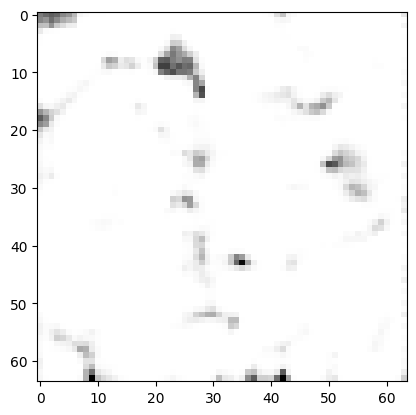

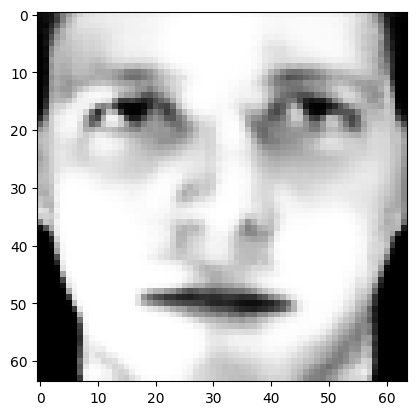

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


loss:  1.9285683631896973  l_d:  0.1009388193488121  l_e:  0.1009388118982315  l_g:  0.17266908288002014
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


loss:  2.0648975372314453  l_d:  0.28965523838996887  l_e:  0.28965523838996887  l_g:  0.14855870604515076
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


loss:  1.4943211078643799  l_d:  0.10065935552120209  l_e:  0.10065935552120209  l_g:  0.12930023670196533
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


loss:  1.436556339263916  l_d:  0.15856581926345825  l_e:  0.15856581926345825  l_g:  0.11194247007369995
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


loss:  1.6066688299179077  l_d:  0.17055743932724  l_e:  0.17055743932724  l_g:  0.126555398106575
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 15.84it/s]


loss:  1.9830451011657715  l_d:  0.11538739502429962  l_e:  0.11538739502429962  l_g:  0.17522703111171722
Epoch 87 : 


100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


loss:  2.5046708583831787  l_d:  0.28223705291748047  l_e:  0.28223705291748047  l_g:  0.19401967525482178
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 15.57it/s]


loss:  1.5613549947738647  l_d:  0.10562069714069366  l_e:  0.10562069714069366  l_g:  0.13501136004924774
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


loss:  1.45161771774292  l_d:  0.11740277707576752  l_e:  0.11740276962518692  l_g:  0.12168121337890625
Epoch 90 : 


100%|██████████| 50/50 [00:04<00:00, 12.36it/s]


loss:  2.0415263175964355  l_d:  0.10275079309940338  l_e:  0.10275079309940338  l_g:  0.1836024820804596


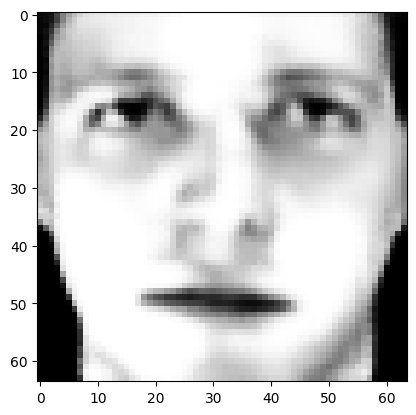

Epoch 91 : 


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


loss:  1.08171546459198  l_d:  0.10785496234893799  l_e:  0.10785496234893799  l_g:  0.08660055696964264
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


loss:  2.183990716934204  l_d:  0.10616782307624817  l_e:  0.10616783052682877  l_g:  0.19716550409793854
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


loss:  1.98878014087677  l_d:  0.21941976249217987  l_e:  0.21941977739334106  l_g:  0.15499405562877655
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


loss:  1.840289831161499  l_d:  0.2940014600753784  l_e:  0.2940014600753784  l_g:  0.12522868812084198
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


loss:  1.697137713432312  l_d:  0.09989757835865021  l_e:  0.09989757835865021  l_g:  0.1497342586517334
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


loss:  1.8280103206634521  l_d:  0.0946582555770874  l_e:  0.0946582555770874  l_g:  0.16386938095092773
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


loss:  1.912459373474121  l_d:  0.1799222230911255  l_e:  0.1799222230911255  l_g:  0.15526148676872253
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]


loss:  1.794101357460022  l_d:  0.09854669868946075  l_e:  0.09854670614004135  l_g:  0.15970079600811005
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


loss:  2.0378565788269043  l_d:  0.10876069962978363  l_e:  0.10876069962978363  l_g:  0.182033509016037


In [10]:
train_d2c(100, 0.001, 1, 0.0000, 10)

Epoch 0 : 


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


loss:  2.134577751159668  l_d:  0.20982077717781067  l_e:  0.20982077717781067  l_g:  0.17149361968040466


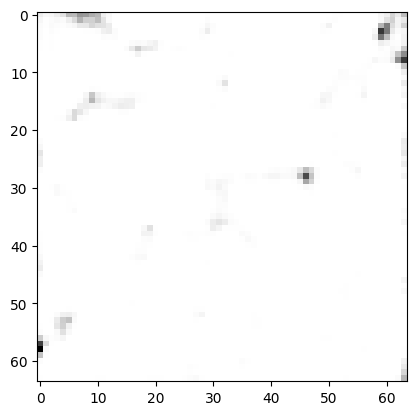

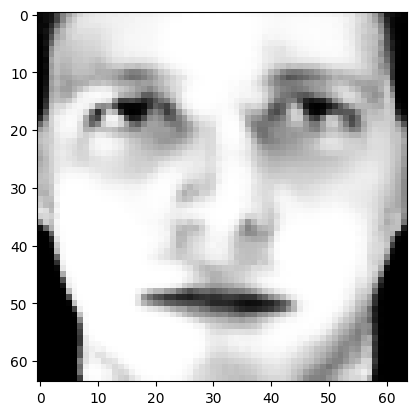

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


loss:  1.3684452772140503  l_d:  0.09924500435590744  l_e:  0.09924499690532684  l_g:  0.11699552834033966
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


loss:  1.3219735622406006  l_d:  0.10586134344339371  l_e:  0.10586134344339371  l_g:  0.11102508008480072
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  1.6243038177490234  l_d:  0.10396720468997955  l_e:  0.10396720468997955  l_g:  0.1416369378566742
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  2.4098398685455322  l_d:  0.19201765954494476  l_e:  0.19201767444610596  l_g:  0.20258045196533203
Epoch 5 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  1.2657296657562256  l_d:  0.09785040467977524  l_e:  0.09785041213035583  l_g:  0.10700288414955139
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


loss:  1.5713675022125244  l_d:  0.21697622537612915  l_e:  0.21697622537612915  l_g:  0.11374150961637497
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


loss:  2.0550155639648438  l_d:  0.12889298796653748  l_e:  0.12889298796653748  l_g:  0.17972296476364136
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  2.476886034011841  l_d:  0.22012603282928467  l_e:  0.22012603282928467  l_g:  0.2036634087562561
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 16.22it/s]


loss:  1.267144799232483  l_d:  0.0957598090171814  l_e:  0.0957598090171814  l_g:  0.10756251215934753
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  1.4350899457931519  l_d:  0.0952204018831253  l_e:  0.09522039443254471  l_g:  0.12446492165327072


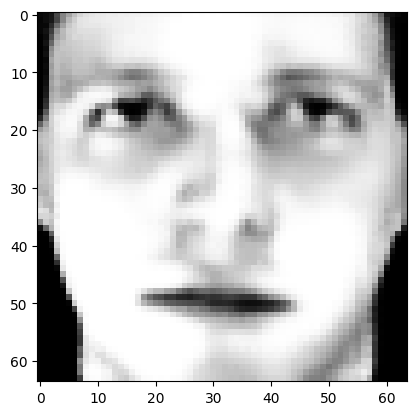

Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


loss:  1.099956750869751  l_d:  0.0960976630449295  l_e:  0.0960976630449295  l_g:  0.09077613800764084
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.1837188005447388  l_d:  0.11966428905725479  l_e:  0.11966428905725479  l_g:  0.09443901479244232
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


loss:  1.6381007432937622  l_d:  0.11839507520198822  l_e:  0.11839507520198822  l_g:  0.14013105630874634
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 14.82it/s]


loss:  1.2428371906280518  l_d:  0.09197194129228592  l_e:  0.09197193384170532  l_g:  0.10588933527469635
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  1.4883456230163574  l_d:  0.09579089283943176  l_e:  0.09579089283943176  l_g:  0.12967638671398163
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  1.9065141677856445  l_d:  0.13310760259628296  l_e:  0.13310760259628296  l_g:  0.16402989625930786
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


loss:  1.888963222503662  l_d:  0.09660106897354126  l_e:  0.09660106897354126  l_g:  0.16957610845565796
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


loss:  1.3190360069274902  l_d:  0.09540995955467224  l_e:  0.09540995955467224  l_g:  0.11282160133123398
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


loss:  1.3083912134170532  l_d:  0.0970505028963089  l_e:  0.0970505028963089  l_g:  0.11142902076244354
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


loss:  2.226482391357422  l_d:  0.2691093981266022  l_e:  0.2691093683242798  l_g:  0.16882635653018951


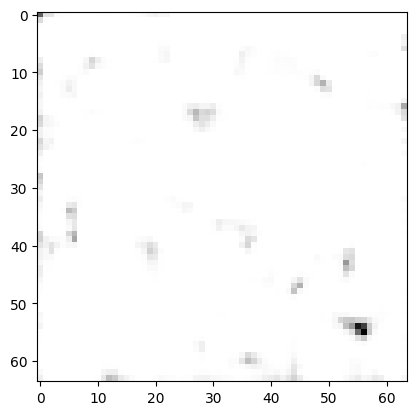

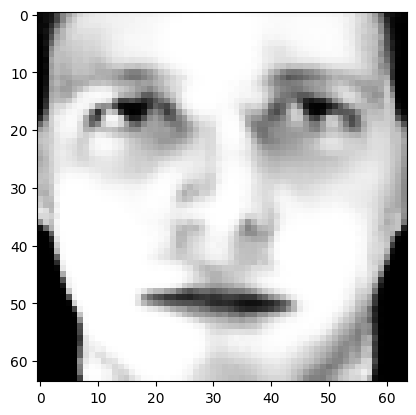

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 15.02it/s]


loss:  1.3690983057022095  l_d:  0.09676618874073029  l_e:  0.09676618874073029  l_g:  0.1175566017627716
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


loss:  2.0894675254821777  l_d:  0.09255397319793701  l_e:  0.09255397319793701  l_g:  0.19043594598770142
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 13.29it/s]


loss:  1.8417154550552368  l_d:  0.13073503971099854  l_e:  0.13073503971099854  l_g:  0.15802453458309174
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


loss:  1.4131637811660767  l_d:  0.13792651891708374  l_e:  0.13792648911476135  l_g:  0.11373107135295868
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  1.3674691915512085  l_d:  0.09459058195352554  l_e:  0.09459058195352554  l_g:  0.11782879382371902
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 15.33it/s]


loss:  2.217176675796509  l_d:  0.14199796319007874  l_e:  0.14199796319007874  l_g:  0.19331806898117065
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 14.84it/s]


loss:  1.31437349319458  l_d:  0.09764441847801208  l_e:  0.09764441847801208  l_g:  0.11190846562385559
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  1.7806469202041626  l_d:  0.12702588737010956  l_e:  0.12702588737010956  l_g:  0.15265950560569763
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


loss:  1.2564561367034912  l_d:  0.09994584321975708  l_e:  0.09994584321975708  l_g:  0.1056564450263977
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  2.0108888149261475  l_d:  0.2198411375284195  l_e:  0.2198411524295807  l_g:  0.15712064504623413


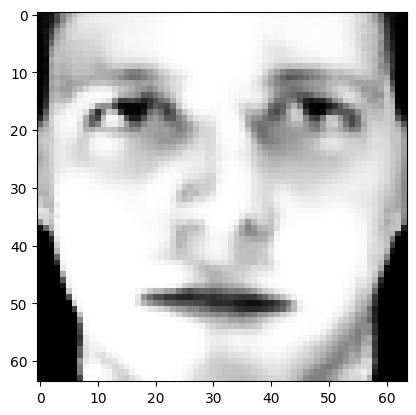

Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


loss:  1.913184404373169  l_d:  0.10648931562900543  l_e:  0.10648931562900543  l_g:  0.17002058029174805
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  1.1908986568450928  l_d:  0.09602982550859451  l_e:  0.09602982550859451  l_g:  0.09988389909267426
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


loss:  1.8219525814056396  l_d:  0.10193827748298645  l_e:  0.10193827748298645  l_g:  0.1618076115846634
Epoch 34 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  2.1102170944213867  l_d:  0.10166488587856293  l_e:  0.10166488587856293  l_g:  0.19068872928619385
Epoch 35 : 


100%|██████████| 50/50 [00:04<00:00, 11.98it/s]


loss:  1.4305250644683838  l_d:  0.10083499550819397  l_e:  0.10083499550819397  l_g:  0.12288551777601242
Epoch 36 : 


100%|██████████| 50/50 [00:04<00:00, 11.94it/s]


loss:  1.6510698795318604  l_d:  0.10173322260379791  l_e:  0.10173322260379791  l_g:  0.1447603404521942
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


loss:  1.3095946311950684  l_d:  0.11465604603290558  l_e:  0.11465604603290558  l_g:  0.10802825540304184
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 12.59it/s]


loss:  1.7595744132995605  l_d:  0.12606504559516907  l_e:  0.12606506049633026  l_g:  0.15074443817138672
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


loss:  1.2575122117996216  l_d:  0.1390957534313202  l_e:  0.1390957534313202  l_g:  0.09793207049369812
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


loss:  1.7407190799713135  l_d:  0.0986718237400055  l_e:  0.0986718237400055  l_g:  0.1543375551700592


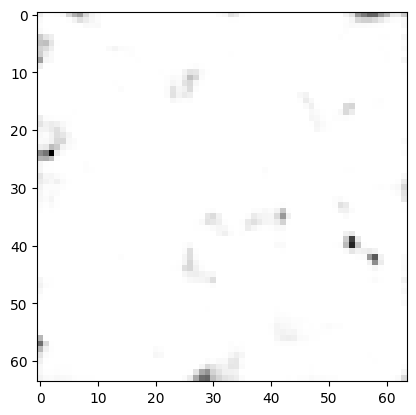

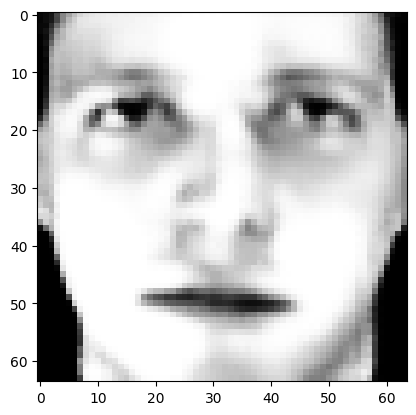

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 12.63it/s]


loss:  1.9725358486175537  l_d:  0.140166774392128  l_e:  0.140166774392128  l_g:  0.1692202389240265
Epoch 42 : 


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]


loss:  2.3404929637908936  l_d:  0.09605799615383148  l_e:  0.09605799615383148  l_g:  0.2148377001285553
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


loss:  1.6860365867614746  l_d:  0.10005465894937515  l_e:  0.10005466639995575  l_g:  0.1485927253961563
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


loss:  2.083719253540039  l_d:  0.15566018223762512  l_e:  0.15566018223762512  l_g:  0.17723987996578217
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


loss:  1.123336911201477  l_d:  0.12543797492980957  l_e:  0.12543797492980957  l_g:  0.08724609762430191
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


loss:  1.2160370349884033  l_d:  0.09579715877771378  l_e:  0.09579715877771378  l_g:  0.10244426876306534
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


loss:  1.9511748552322388  l_d:  0.11767540872097015  l_e:  0.11767540872097015  l_g:  0.1715824007987976
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


loss:  1.6694276332855225  l_d:  0.09404788911342621  l_e:  0.09404788911342621  l_g:  0.14813318848609924
Epoch 49 : 


100%|██████████| 50/50 [00:03<00:00, 13.41it/s]


loss:  1.7082765102386475  l_d:  0.09393420815467834  l_e:  0.09393420815467834  l_g:  0.15204080939292908
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


loss:  1.881775140762329  l_d:  0.09325514733791351  l_e:  0.09325514733791351  l_g:  0.16952648758888245


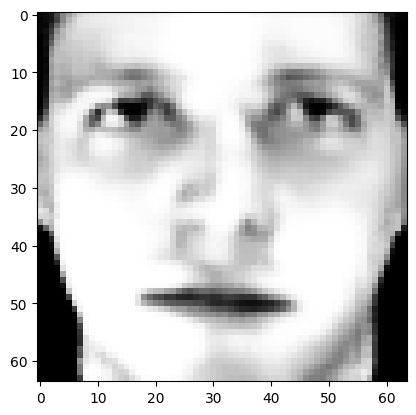

Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  1.4530630111694336  l_d:  0.13128699362277985  l_e:  0.13128697872161865  l_g:  0.11904890835285187
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


loss:  1.6516010761260986  l_d:  0.09275368601083755  l_e:  0.09275368601083755  l_g:  0.146609365940094
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


loss:  1.3620365858078003  l_d:  0.09595882147550583  l_e:  0.09595882147550583  l_g:  0.1170118898153305
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 15.03it/s]


loss:  1.6389952898025513  l_d:  0.1070445328950882  l_e:  0.1070445328950882  l_g:  0.14249062538146973
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


loss:  1.9437150955200195  l_d:  0.09822097420692444  l_e:  0.09822097420692444  l_g:  0.17472732067108154
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


loss:  2.142774820327759  l_d:  0.10121779143810272  l_e:  0.10121779143810272  l_g:  0.1940339356660843
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.7359517812728882  l_d:  0.09530192613601685  l_e:  0.09530192613601685  l_g:  0.15453478693962097
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


loss:  1.9459158182144165  l_d:  0.10579507052898407  l_e:  0.10579507052898407  l_g:  0.17343255877494812
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


loss:  1.9338157176971436  l_d:  0.11913326382637024  l_e:  0.11913326382637024  l_g:  0.1695549190044403
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


loss:  1.9265129566192627  l_d:  0.18775327503681183  l_e:  0.18775327503681183  l_g:  0.15510064363479614


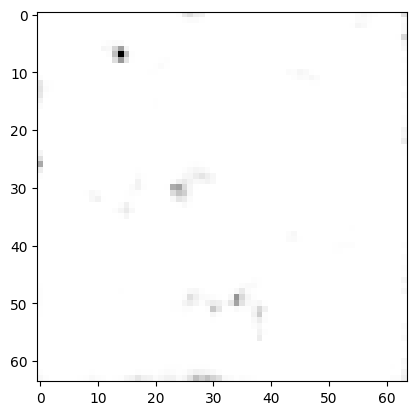

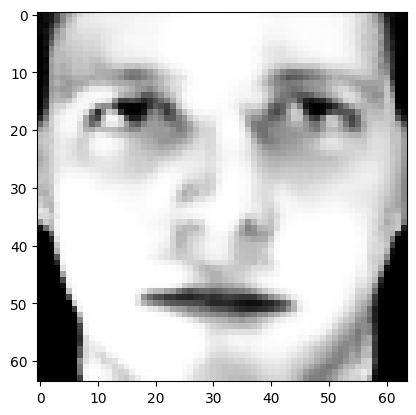

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.8071496486663818  l_d:  0.13151705265045166  l_e:  0.13151705265045166  l_g:  0.15441155433654785
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  1.420535683631897  l_d:  0.09033606201410294  l_e:  0.09033606201410294  l_g:  0.12398634850978851
Epoch 63 : 


100%|██████████| 50/50 [00:04<00:00, 11.97it/s]


loss:  1.9076204299926758  l_d:  0.10081800818443298  l_e:  0.10081801563501358  l_g:  0.17059844732284546
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


loss:  1.3041481971740723  l_d:  0.08939680457115173  l_e:  0.08939680457115173  l_g:  0.11253544688224792
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


loss:  1.2363537549972534  l_d:  0.1014188677072525  l_e:  0.1014188677072525  l_g:  0.10335160791873932
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  1.8207128047943115  l_d:  0.0952693372964859  l_e:  0.0952693372964859  l_g:  0.1630174219608307
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


loss:  1.8358856439590454  l_d:  0.10059159994125366  l_e:  0.10059159994125366  l_g:  0.16347023844718933
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


loss:  1.156557559967041  l_d:  0.09093184769153595  l_e:  0.09093184769153595  l_g:  0.09746938198804855
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  1.4701396226882935  l_d:  0.10070683062076569  l_e:  0.10070683062076569  l_g:  0.12687259912490845
Epoch 70 : 


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


loss:  1.9217793941497803  l_d:  0.10674680769443512  l_e:  0.10674680769443512  l_g:  0.17082858085632324


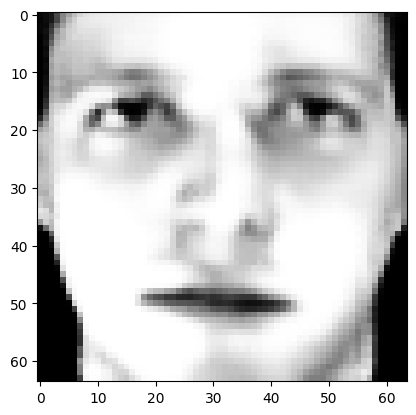

Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 14.80it/s]


loss:  1.9393473863601685  l_d:  0.1010093167424202  l_e:  0.1010093092918396  l_g:  0.17373287677764893
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 16.03it/s]


loss:  1.684597134590149  l_d:  0.10769155621528625  l_e:  0.10769154131412506  l_g:  0.14692141115665436
Epoch 73 : 


100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


loss:  1.519950032234192  l_d:  0.15659970045089722  l_e:  0.15659970045089722  l_g:  0.12067505717277527
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


loss:  1.2238521575927734  l_d:  0.09571263194084167  l_e:  0.09571263194084167  l_g:  0.10324269533157349
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


loss:  0.8230742812156677  l_d:  0.09693595767021179  l_e:  0.09693595767021179  l_g:  0.0629202350974083
Epoch 76 : 


100%|██████████| 50/50 [00:04<00:00, 12.06it/s]


loss:  1.6581132411956787  l_d:  0.17531761527061462  l_e:  0.17531761527061462  l_g:  0.13074779510498047
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 12.78it/s]


loss:  2.0432376861572266  l_d:  0.23957443237304688  l_e:  0.23957443237304688  l_g:  0.1564088761806488
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


loss:  1.1844122409820557  l_d:  0.09294691681861877  l_e:  0.09294691681861877  l_g:  0.09985184669494629
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


loss:  1.8410954475402832  l_d:  0.11022665351629257  l_e:  0.11022666096687317  l_g:  0.16206422448158264
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 15.14it/s]


loss:  1.5567902326583862  l_d:  0.09783649444580078  l_e:  0.09783649444580078  l_g:  0.13611172139644623


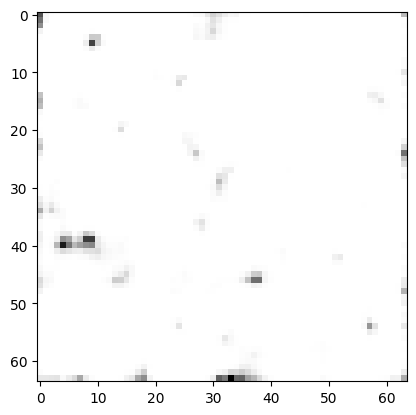

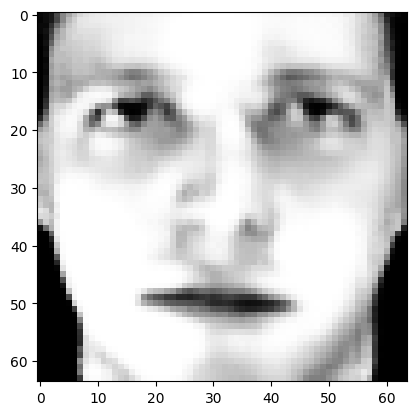

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  2.1960904598236084  l_d:  0.10829700529575348  l_e:  0.10829700529575348  l_g:  0.19794964790344238
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


loss:  1.3762377500534058  l_d:  0.10183914005756378  l_e:  0.10183914005756378  l_g:  0.11725595593452454
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


loss:  1.419479250907898  l_d:  0.10662201792001724  l_e:  0.10662201792001724  l_g:  0.12062351405620575
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


loss:  1.5579289197921753  l_d:  0.10593812167644501  l_e:  0.1059381291270256  l_g:  0.1346052587032318
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  1.5763804912567139  l_d:  0.09862080216407776  l_e:  0.09862080216407776  l_g:  0.13791388273239136
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  1.9863250255584717  l_d:  0.10262970626354218  l_e:  0.10262970626354218  l_g:  0.17810656130313873
Epoch 87 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  1.7291110754013062  l_d:  0.0968363881111145  l_e:  0.0968363881111145  l_g:  0.15354382991790771
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  1.125689148902893  l_d:  0.10816314071416855  l_e:  0.10816314071416855  l_g:  0.09093628823757172
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


loss:  1.4742820262908936  l_d:  0.10997330397367477  l_e:  0.10997329652309418  l_g:  0.1254335343837738
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


loss:  1.7264690399169922  l_d:  0.09295657277107239  l_e:  0.09295657277107239  l_g:  0.15405559539794922


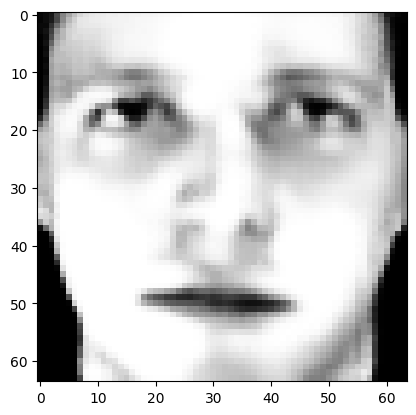

Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.97it/s]


loss:  1.2906827926635742  l_d:  0.1115276888012886  l_e:  0.11152768135070801  l_g:  0.10676274448633194
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


loss:  1.4056228399276733  l_d:  0.0910458043217659  l_e:  0.0910457968711853  l_g:  0.12235312163829803
Epoch 93 : 


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


loss:  1.6335537433624268  l_d:  0.0920579731464386  l_e:  0.0920579731464386  l_g:  0.14494377374649048
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.8180952072143555  l_d:  0.09380076825618744  l_e:  0.09380076825618744  l_g:  0.1630493700504303
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  1.3372653722763062  l_d:  0.09308897703886032  l_e:  0.09308897703886032  l_g:  0.11510874330997467
Epoch 96 : 


100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


loss:  1.7222727537155151  l_d:  0.24819958209991455  l_e:  0.24819958209991455  l_g:  0.12258736044168472
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 12.78it/s]


loss:  1.6642279624938965  l_d:  0.09780651330947876  l_e:  0.09780651330947876  l_g:  0.1468614935874939
Epoch 98 : 


100%|██████████| 50/50 [00:04<00:00, 12.01it/s]


loss:  1.675217866897583  l_d:  0.10967439413070679  l_e:  0.10967439413070679  l_g:  0.14558690786361694
Epoch 99 : 


100%|██████████| 50/50 [00:04<00:00, 11.78it/s]


loss:  1.6119338274002075  l_d:  0.09888119995594025  l_e:  0.09888119995594025  l_g:  0.14141714572906494
Epoch 100 : 


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


loss:  1.5681511163711548  l_d:  0.09529203176498413  l_e:  0.09529203176498413  l_g:  0.13775670528411865


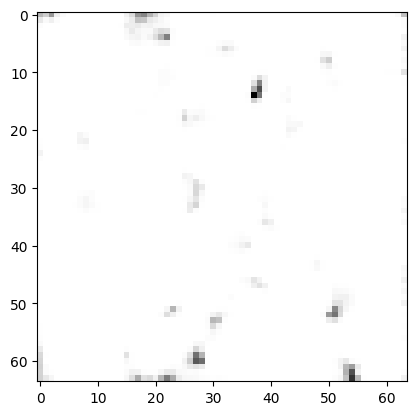

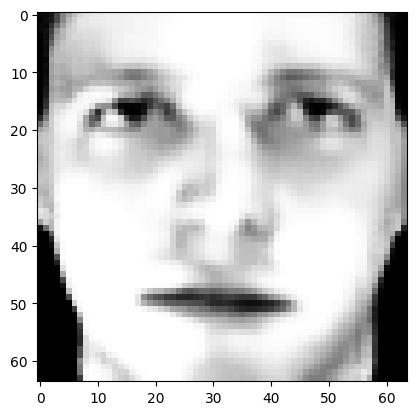

Epoch 101 : 


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


loss:  1.465822458267212  l_d:  0.09666113555431366  l_e:  0.09666113555431366  l_g:  0.12725001573562622
Epoch 102 : 


100%|██████████| 50/50 [00:04<00:00, 12.01it/s]


loss:  1.8497061729431152  l_d:  0.09619055688381195  l_e:  0.09619055688381195  l_g:  0.1657325029373169
Epoch 103 : 


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


loss:  1.4247797727584839  l_d:  0.09921590983867645  l_e:  0.09921590983867645  l_g:  0.12263479083776474
Epoch 104 : 


100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


loss:  1.3837295770645142  l_d:  0.2250710278749466  l_e:  0.2250710278749466  l_g:  0.09335874766111374
Epoch 105 : 


100%|██████████| 50/50 [00:03<00:00, 14.16it/s]


loss:  1.572279930114746  l_d:  0.09345827996730804  l_e:  0.09345827996730804  l_g:  0.13853633403778076
Epoch 106 : 


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


loss:  1.5663516521453857  l_d:  0.09233798086643219  l_e:  0.09233798086643219  l_g:  0.1381675750017166
Epoch 107 : 


100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


loss:  1.4153175354003906  l_d:  0.09131285548210144  l_e:  0.09131285548210144  l_g:  0.12326918542385101
Epoch 108 : 


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


loss:  1.6728765964508057  l_d:  0.21092341840267181  l_e:  0.21092341840267181  l_g:  0.1251029670238495
Epoch 109 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  1.6490557193756104  l_d:  0.09946411103010178  l_e:  0.09946411103010178  l_g:  0.1450127512216568
Epoch 110 : 


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


loss:  1.9844677448272705  l_d:  0.0914473757147789  l_e:  0.0914473757147789  l_g:  0.18015730381011963


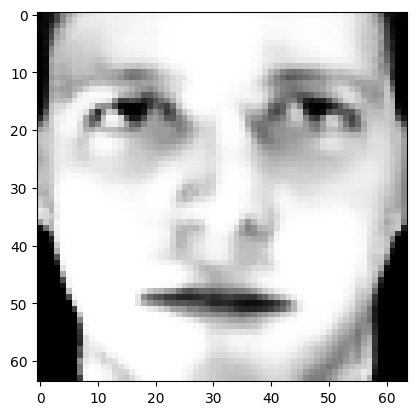

Epoch 111 : 


100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


loss:  1.808319091796875  l_d:  0.1572371870279312  l_e:  0.1572371870279312  l_g:  0.14938446879386902
Epoch 112 : 


100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


loss:  1.7272143363952637  l_d:  0.09546934068202972  l_e:  0.09546934068202972  l_g:  0.15362755954265594
Epoch 113 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  1.5117148160934448  l_d:  0.11110500991344452  l_e:  0.11110500991344452  l_g:  0.12895047664642334
Epoch 114 : 


100%|██████████| 50/50 [00:03<00:00, 15.89it/s]


loss:  1.0992319583892822  l_d:  0.10360559821128845  l_e:  0.10360559821128845  l_g:  0.08920207619667053
Epoch 115 : 


100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


loss:  1.581620693206787  l_d:  0.09264413267374039  l_e:  0.09264413267374039  l_g:  0.13963323831558228
Epoch 116 : 


100%|██████████| 50/50 [00:03<00:00, 16.50it/s]


loss:  1.634301781654358  l_d:  0.09191680699586868  l_e:  0.09191681444644928  l_g:  0.14504681527614594
Epoch 117 : 


100%|██████████| 50/50 [00:03<00:00, 16.38it/s]


loss:  1.9419487714767456  l_d:  0.10655026882886887  l_e:  0.10655026882886887  l_g:  0.17288482189178467
Epoch 118 : 


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


loss:  1.6338226795196533  l_d:  0.0925377905368805  l_e:  0.0925377905368805  l_g:  0.1448747217655182
Epoch 119 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  1.7451497316360474  l_d:  0.09726791083812714  l_e:  0.09726791083812714  l_g:  0.15506139397621155
Epoch 120 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  1.2786355018615723  l_d:  0.10432136803865433  l_e:  0.10432136803865433  l_g:  0.10699927806854248


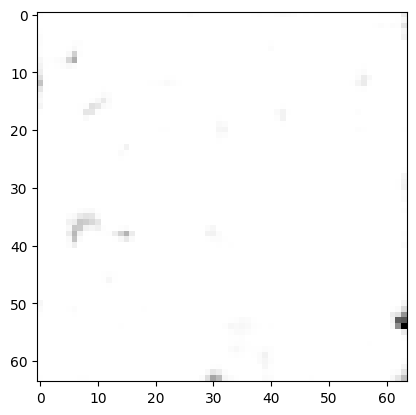

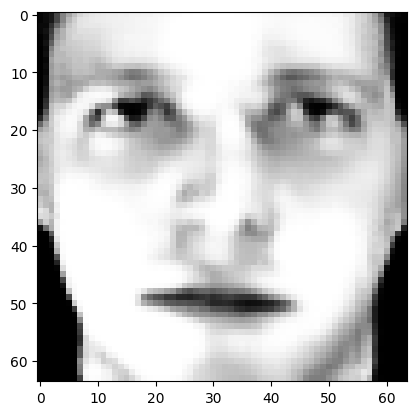

Epoch 121 : 


100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


loss:  1.6233376264572144  l_d:  0.09268645942211151  l_e:  0.09268645942211151  l_g:  0.14379647374153137
Epoch 122 : 


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


loss:  1.6761643886566162  l_d:  0.08941203355789185  l_e:  0.08941203355789185  l_g:  0.1497340351343155
Epoch 123 : 


100%|██████████| 50/50 [00:03<00:00, 14.25it/s]


loss:  1.6902155876159668  l_d:  0.09125839173793793  l_e:  0.09125839173793793  l_g:  0.15076987445354462
Epoch 124 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.8115829229354858  l_d:  0.15039348602294922  l_e:  0.15039348602294922  l_g:  0.15107959508895874
Epoch 125 : 


100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


loss:  1.8362059593200684  l_d:  0.09205223619937897  l_e:  0.09205223619937897  l_g:  0.16521015763282776
Epoch 126 : 


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


loss:  1.748622179031372  l_d:  0.15275825560092926  l_e:  0.15275825560092926  l_g:  0.14431056380271912
Epoch 127 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  1.9402334690093994  l_d:  0.09246145933866501  l_e:  0.09246145933866501  l_g:  0.1755310595035553
Epoch 128 : 


100%|██████████| 50/50 [00:03<00:00, 13.76it/s]


loss:  2.0147383213043213  l_d:  0.19016557931900024  l_e:  0.19016557931900024  l_g:  0.16344071924686432
Epoch 129 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  2.1323657035827637  l_d:  0.10099337995052338  l_e:  0.10099337995052338  l_g:  0.19303789734840393
Epoch 130 : 


100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


loss:  1.4785220623016357  l_d:  0.10701897740364075  l_e:  0.10701897740364075  l_g:  0.12644842267036438


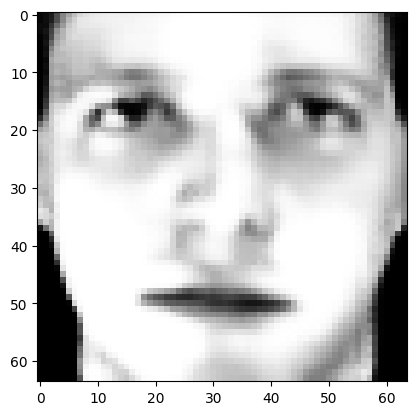

Epoch 131 : 


100%|██████████| 50/50 [00:03<00:00, 13.95it/s]


loss:  1.7819219827651978  l_d:  0.09218128025531769  l_e:  0.09218128770589828  l_g:  0.15975594520568848
Epoch 132 : 


100%|██████████| 50/50 [00:03<00:00, 12.56it/s]


loss:  1.6993076801300049  l_d:  0.10076841711997986  l_e:  0.10076841711997986  l_g:  0.14977708458900452
Epoch 133 : 


100%|██████████| 50/50 [00:03<00:00, 12.79it/s]


loss:  1.3640334606170654  l_d:  0.11631262302398682  l_e:  0.11631262302398682  l_g:  0.11314082145690918
Epoch 134 : 


100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


loss:  1.5523310899734497  l_d:  0.08955997228622437  l_e:  0.08955997228622437  l_g:  0.1373211145401001
Epoch 135 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  1.3362340927124023  l_d:  0.0923018679022789  l_e:  0.0923018679022789  l_g:  0.11516304314136505
Epoch 136 : 


100%|██████████| 50/50 [00:03<00:00, 12.85it/s]


loss:  1.3562928438186646  l_d:  0.09872440248727798  l_e:  0.09872440248727798  l_g:  0.11588440090417862
Epoch 137 : 


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


loss:  1.6967546939849854  l_d:  0.21077363193035126  l_e:  0.21077361702919006  l_g:  0.12752074003219604
Epoch 138 : 


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


loss:  1.1724151372909546  l_d:  0.09428434818983078  l_e:  0.09428434818983078  l_g:  0.09838464856147766
Epoch 139 : 


100%|██████████| 50/50 [00:03<00:00, 15.71it/s]


loss:  1.4880369901657104  l_d:  0.09103082865476608  l_e:  0.09103083610534668  l_g:  0.1305975317955017
Epoch 140 : 


100%|██████████| 50/50 [00:03<00:00, 14.83it/s]


loss:  2.0575993061065674  l_d:  0.16113457083702087  l_e:  0.16113457083702087  l_g:  0.17353302240371704


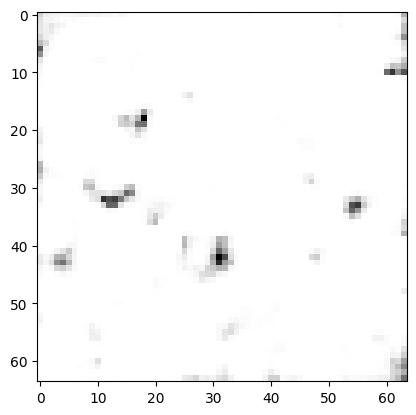

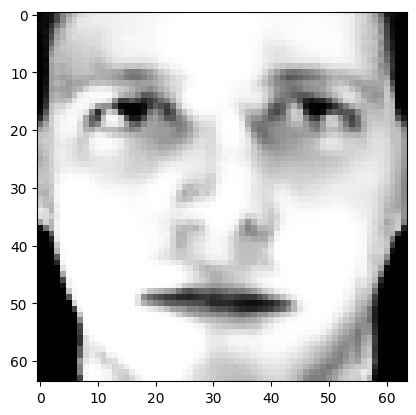

Epoch 141 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  2.2274279594421387  l_d:  0.13394717872142792  l_e:  0.1339471936225891  l_g:  0.195953369140625
Epoch 142 : 


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


loss:  1.505963683128357  l_d:  0.09631019830703735  l_e:  0.09631019830703735  l_g:  0.1313343346118927
Epoch 143 : 


100%|██████████| 50/50 [00:03<00:00, 15.62it/s]


loss:  2.017345428466797  l_d:  0.1044965460896492  l_e:  0.1044965460896492  l_g:  0.18083523213863373
Epoch 144 : 


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


loss:  1.5722181797027588  l_d:  0.1422228217124939  l_e:  0.1422228217124939  l_g:  0.12877725064754486
Epoch 145 : 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


loss:  1.263901710510254  l_d:  0.0914076417684555  l_e:  0.0914076417684555  l_g:  0.10810863971710205
Epoch 146 : 


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


loss:  2.514462471008301  l_d:  0.09196288138628006  l_e:  0.09196288138628006  l_g:  0.23305366933345795
Epoch 147 : 


100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


loss:  1.60203218460083  l_d:  0.10249508172273636  l_e:  0.10249508172273636  l_g:  0.13970419764518738
Epoch 148 : 


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


loss:  2.2575690746307373  l_d:  0.11621151119470596  l_e:  0.11621150374412537  l_g:  0.20251458883285522
Epoch 149 : 


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


loss:  1.282978892326355  l_d:  0.10735941678285599  l_e:  0.10735940933227539  l_g:  0.10682600736618042
Epoch 150 : 


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


loss:  1.4188426733016968  l_d:  0.16422688961029053  l_e:  0.16422688961029053  l_g:  0.10903888940811157


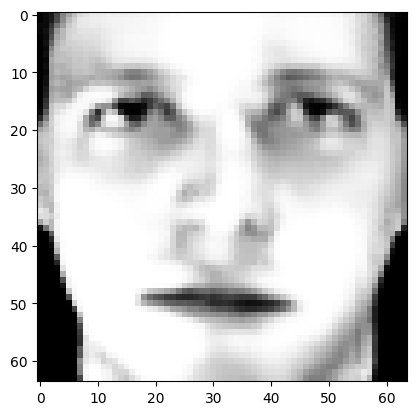

Epoch 151 : 


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


loss:  2.248283624649048  l_d:  0.0898614302277565  l_e:  0.0898614227771759  l_g:  0.20685608685016632
Epoch 152 : 


100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


loss:  1.8766230344772339  l_d:  0.26131850481033325  l_e:  0.26131850481033325  l_g:  0.13539859652519226
Epoch 153 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  2.4379706382751465  l_d:  0.10811619460582733  l_e:  0.10811619460582733  l_g:  0.22217382490634918
Epoch 154 : 


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


loss:  1.2357608079910278  l_d:  0.08851997554302216  l_e:  0.08851997554302216  l_g:  0.10587208718061447
Epoch 155 : 


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


loss:  1.2656995058059692  l_d:  0.10632853955030441  l_e:  0.10632853955030441  l_g:  0.10530424118041992
Epoch 156 : 


100%|██████████| 50/50 [00:03<00:00, 12.67it/s]


loss:  1.9704909324645996  l_d:  0.12752963602542877  l_e:  0.12752963602542877  l_g:  0.1715431660413742
Epoch 157 : 


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


loss:  2.231144905090332  l_d:  0.15580877661705017  l_e:  0.15580879151821136  l_g:  0.19195273518562317
Epoch 158 : 


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


loss:  1.1307880878448486  l_d:  0.11239530146121979  l_e:  0.11239530146121979  l_g:  0.09059974551200867
Epoch 159 : 


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


loss:  1.192314624786377  l_d:  0.09639732539653778  l_e:  0.09639732539653778  l_g:  0.09995199739933014
Epoch 160 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  1.3538408279418945  l_d:  0.09855273365974426  l_e:  0.09855273365974426  l_g:  0.11567352712154388


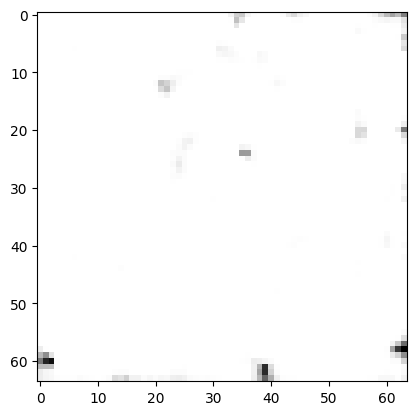

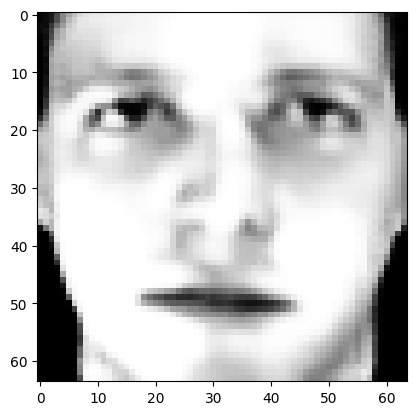

Epoch 161 : 


100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


loss:  1.6751993894577026  l_d:  0.09195899963378906  l_e:  0.09195899963378906  l_g:  0.14912813901901245
Epoch 162 : 


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


loss:  1.8084418773651123  l_d:  0.2937595546245575  l_e:  0.2937595546245575  l_g:  0.12209227681159973
Epoch 163 : 


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


loss:  1.5361356735229492  l_d:  0.11303830146789551  l_e:  0.1130383089184761  l_g:  0.1310059130191803
Epoch 164 : 


100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


loss:  1.3417447805404663  l_d:  0.10423571616411209  l_e:  0.10423572361469269  l_g:  0.11332733184099197
Epoch 165 : 


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


loss:  1.1595028638839722  l_d:  0.09303151071071625  l_e:  0.09303151071071625  l_g:  0.09734398126602173
Epoch 166 : 


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


loss:  2.108598470687866  l_d:  0.10350507497787476  l_e:  0.10350507497787476  l_g:  0.19015882909297943
Epoch 167 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  1.2791515588760376  l_d:  0.09246170520782471  l_e:  0.09246170520782471  l_g:  0.10942281037569046
Epoch 168 : 


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


loss:  1.6505112648010254  l_d:  0.11344476044178009  l_e:  0.11344476044178009  l_g:  0.14236217737197876
Epoch 169 : 


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


loss:  1.3182319402694702  l_d:  0.09232233464717865  l_e:  0.09232233464717865  l_g:  0.11335872113704681
Epoch 170 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  1.5265483856201172  l_d:  0.11521226167678833  l_e:  0.11521226167678833  l_g:  0.12961238622665405


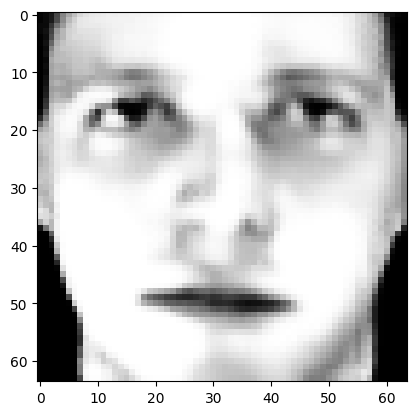

Epoch 171 : 


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


loss:  1.4357925653457642  l_d:  0.11164088547229767  l_e:  0.11164088547229767  l_g:  0.12125107645988464
Epoch 172 : 


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


loss:  1.5371967554092407  l_d:  0.09341640025377274  l_e:  0.09341639280319214  l_g:  0.1350363940000534
Epoch 173 : 


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


loss:  1.3463761806488037  l_d:  0.08962288498878479  l_e:  0.08962288498878479  l_g:  0.1167130395770073
Epoch 174 : 


100%|██████████| 50/50 [00:04<00:00, 12.07it/s]


loss:  1.6200464963912964  l_d:  0.09246201068162918  l_e:  0.09246201068162918  l_g:  0.14351224899291992
Epoch 175 : 


100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


loss:  1.9206361770629883  l_d:  0.08779308199882507  l_e:  0.08779308199882507  l_g:  0.17450499534606934
Epoch 176 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  1.3976709842681885  l_d:  0.09314019978046417  l_e:  0.09314020723104477  l_g:  0.1211390569806099
Epoch 177 : 


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


loss:  1.769862174987793  l_d:  0.08881284296512604  l_e:  0.08881283551454544  l_g:  0.15922364592552185
Epoch 178 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  1.4377332925796509  l_d:  0.09276100248098373  l_e:  0.09276099503040314  l_g:  0.1252211332321167
Epoch 179 : 


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


loss:  1.3464397192001343  l_d:  0.08978910744190216  l_e:  0.08978910744190216  l_g:  0.116686150431633
Epoch 180 : 


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


loss:  1.859744668006897  l_d:  0.09112682193517685  l_e:  0.09112682193517685  l_g:  0.16774910688400269


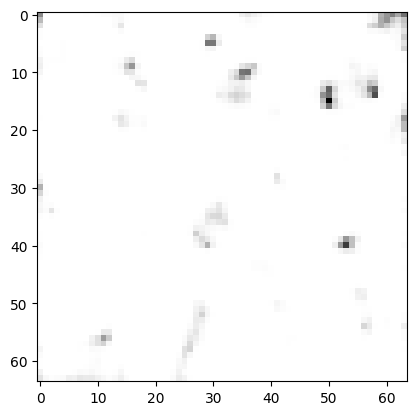

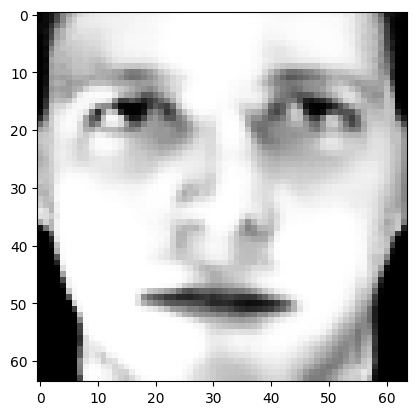

Epoch 181 : 


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


loss:  1.799511432647705  l_d:  0.08811244368553162  l_e:  0.08811245113611221  l_g:  0.16232864558696747
Epoch 182 : 


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


loss:  1.1750359535217285  l_d:  0.10793722420930862  l_e:  0.10793723165988922  l_g:  0.09591615200042725
Epoch 183 : 


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


loss:  1.4301130771636963  l_d:  0.10196207463741302  l_e:  0.10196207463741302  l_g:  0.12261888384819031
Epoch 184 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  1.285663366317749  l_d:  0.09498806297779083  l_e:  0.09498806297779083  l_g:  0.10956872999668121
Epoch 185 : 


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


loss:  2.046581983566284  l_d:  0.1741512417793274  l_e:  0.1741512417793274  l_g:  0.16982795298099518
Epoch 186 : 


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


loss:  1.5013632774353027  l_d:  0.09743426740169525  l_e:  0.09743426740169525  l_g:  0.13064947724342346
Epoch 187 : 


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


loss:  1.3175103664398193  l_d:  0.16155126690864563  l_e:  0.16155125200748444  l_g:  0.09944078326225281
Epoch 188 : 


100%|██████████| 50/50 [00:03<00:00, 15.03it/s]


loss:  1.8308367729187012  l_d:  0.1063394770026207  l_e:  0.1063394844532013  l_g:  0.1618157923221588
Epoch 189 : 


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


loss:  1.617623209953308  l_d:  0.09234654158353806  l_e:  0.09234654158353806  l_g:  0.14329300820827484
Epoch 190 : 


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


loss:  1.2022515535354614  l_d:  0.26379790902137756  l_e:  0.26379790902137756  l_g:  0.06746557354927063


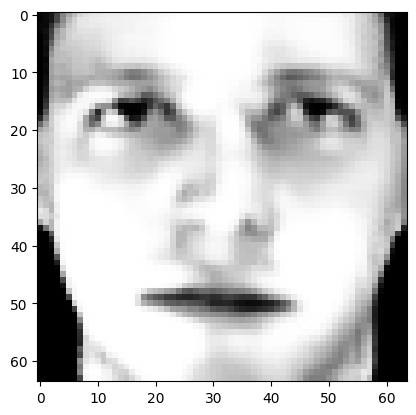

Epoch 191 : 


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


loss:  1.097257375717163  l_d:  0.11389029026031494  l_e:  0.11389029026031494  l_g:  0.08694767951965332
Epoch 192 : 


100%|██████████| 50/50 [00:04<00:00, 11.61it/s]


loss:  1.6472052335739136  l_d:  0.1223667711019516  l_e:  0.12236678600311279  l_g:  0.1402471661567688
Epoch 193 : 


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


loss:  2.1304688453674316  l_d:  0.141892671585083  l_e:  0.141892671585083  l_g:  0.18466836214065552
Epoch 194 : 


100%|██████████| 50/50 [00:04<00:00, 12.50it/s]


loss:  2.15352201461792  l_d:  0.09112909436225891  l_e:  0.09112909436225891  l_g:  0.1971263736486435
Epoch 195 : 


100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


loss:  0.9742692708969116  l_d:  0.09501631557941437  l_e:  0.09501631557941437  l_g:  0.07842366397380829
Epoch 196 : 


100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


loss:  1.2931759357452393  l_d:  0.1280878484249115  l_e:  0.1280878484249115  l_g:  0.10370001196861267
Epoch 197 : 


100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


loss:  1.7763562202453613  l_d:  0.12123891711235046  l_e:  0.12123892456293106  l_g:  0.15338782966136932
Epoch 198 : 


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


loss:  1.9423953294754028  l_d:  0.10975603014230728  l_e:  0.10975603014230728  l_g:  0.17228832840919495
Epoch 199 : 


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


loss:  1.413301706314087  l_d:  0.09510532021522522  l_e:  0.09510532021522522  l_g:  0.122309111058712


In [11]:
train_d2c(200, 0.0005, 1, 0.00001, 10)

Epoch 0 : 


100%|██████████| 50/50 [00:03<00:00, 14.80it/s]


loss:  2.0367918014526367  l_d:  0.09032875299453735  l_e:  0.09032875299453735  l_g:  0.18561342358589172


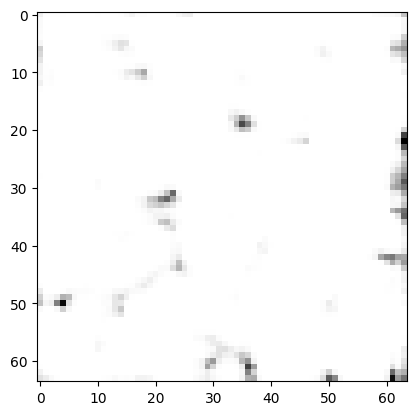

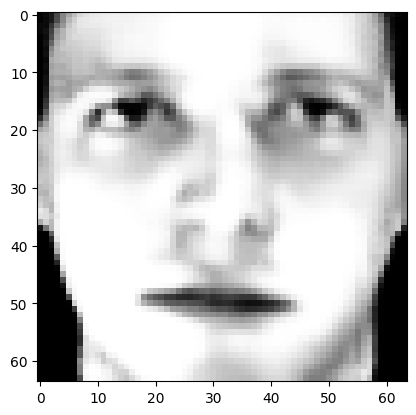

Epoch 1 : 


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


loss:  1.0952081680297852  l_d:  0.09076695889234543  l_e:  0.09076695889234543  l_g:  0.09136743098497391
Epoch 2 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  1.9989556074142456  l_d:  0.10581748187541962  l_e:  0.10581748187541962  l_g:  0.17873206734657288
Epoch 3 : 


100%|██████████| 50/50 [00:03<00:00, 15.02it/s]


loss:  1.2316224575042725  l_d:  0.12142331898212433  l_e:  0.12142331898212433  l_g:  0.09887757897377014
Epoch 4 : 


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


loss:  1.303220510482788  l_d:  0.12738928198814392  l_e:  0.12738928198814392  l_g:  0.10484420508146286
Epoch 5 : 


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


loss:  1.744683027267456  l_d:  0.097341388463974  l_e:  0.097341388463974  l_g:  0.15500003099441528
Epoch 6 : 


100%|██████████| 50/50 [00:03<00:00, 15.29it/s]


loss:  1.2952708005905151  l_d:  0.08664090931415558  l_e:  0.08664091676473618  l_g:  0.11219889670610428
Epoch 7 : 


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


loss:  1.5748957395553589  l_d:  0.10688119381666183  l_e:  0.10688120126724243  l_g:  0.13611333072185516
Epoch 8 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  2.0786936283111572  l_d:  0.28938090801239014  l_e:  0.28938090801239014  l_g:  0.1499931812286377
Epoch 9 : 


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


loss:  2.0777604579925537  l_d:  0.10662747174501419  l_e:  0.10662747174501419  l_g:  0.1864505410194397
Epoch 10 : 


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


loss:  1.3885895013809204  l_d:  0.09648074954748154  l_e:  0.09648074954748154  l_g:  0.11956280469894409


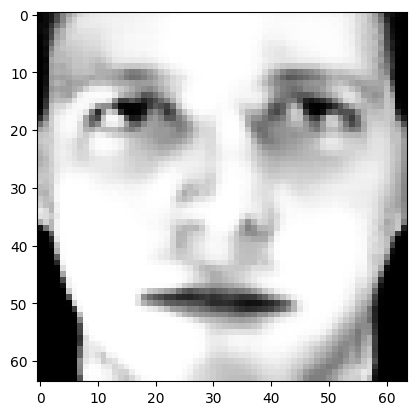

Epoch 11 : 


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


loss:  1.7238354682922363  l_d:  0.1561875343322754  l_e:  0.1561875343322754  l_g:  0.14114603400230408
Epoch 12 : 


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


loss:  2.214200735092163  l_d:  0.09504987299442291  l_e:  0.09504987299442291  l_g:  0.20241010189056396
Epoch 13 : 


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


loss:  2.032015323638916  l_d:  0.10259388387203217  l_e:  0.10259388387203217  l_g:  0.18268276751041412
Epoch 14 : 


100%|██████████| 50/50 [00:03<00:00, 16.06it/s]


loss:  1.6499956846237183  l_d:  0.08669982850551605  l_e:  0.08669982850551605  l_g:  0.14765959978103638
Epoch 15 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.2945610284805298  l_d:  0.08434915542602539  l_e:  0.08434915542602539  l_g:  0.11258627474308014
Epoch 16 : 


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


loss:  1.8006738424301147  l_d:  0.08996288478374481  l_e:  0.08996288478374481  l_g:  0.16207480430603027
Epoch 17 : 


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


loss:  1.4585092067718506  l_d:  0.09707831591367722  l_e:  0.09707831591367722  l_g:  0.12643525004386902
Epoch 18 : 


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


loss:  2.0321462154388428  l_d:  0.0950080007314682  l_e:  0.0950080007314682  l_g:  0.18421301245689392
Epoch 19 : 


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


loss:  1.2273504734039307  l_d:  0.09539353847503662  l_e:  0.09539353847503662  l_g:  0.1036563366651535
Epoch 20 : 


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


loss:  1.1905605792999268  l_d:  0.10143043100833893  l_e:  0.10143044590950012  l_g:  0.09876997768878937


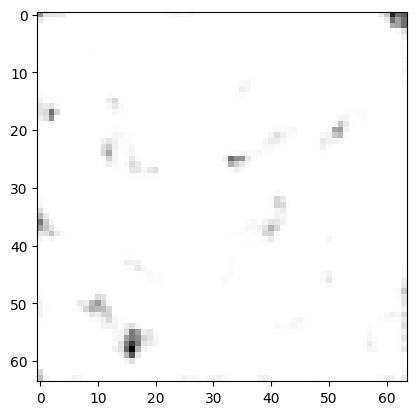

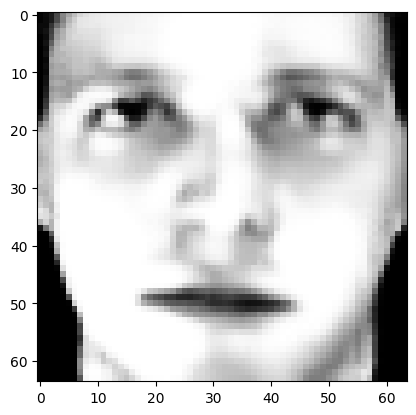

Epoch 21 : 


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


loss:  2.108731746673584  l_d:  0.08764512836933136  l_e:  0.08764512836933136  l_g:  0.1933441460132599
Epoch 22 : 


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]


loss:  1.8123462200164795  l_d:  0.10170599818229675  l_e:  0.10170599073171616  l_g:  0.16089342534542084
Epoch 23 : 


100%|██████████| 50/50 [00:03<00:00, 12.70it/s]


loss:  1.4366614818572998  l_d:  0.08809337764978409  l_e:  0.08809337764978409  l_g:  0.12604746222496033
Epoch 24 : 


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


loss:  1.8085334300994873  l_d:  0.10195162892341614  l_e:  0.10195162892341614  l_g:  0.16046302020549774
Epoch 25 : 


100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


loss:  1.2338666915893555  l_d:  0.11366575956344604  l_e:  0.11366575956344604  l_g:  0.1006535217165947
Epoch 26 : 


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


loss:  1.2249094247817993  l_d:  0.10254977643489838  l_e:  0.10254977643489838  l_g:  0.10198098421096802
Epoch 27 : 


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


loss:  1.5024099349975586  l_d:  0.13664819300174713  l_e:  0.13664819300174713  l_g:  0.12291135638952255
Epoch 28 : 


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


loss:  1.3269447088241577  l_d:  0.09909380972385406  l_e:  0.09909380972385406  l_g:  0.11287571489810944
Epoch 29 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  1.4855413436889648  l_d:  0.08899341523647308  l_e:  0.08899341523647308  l_g:  0.1307554543018341
Epoch 30 : 


100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


loss:  1.0391091108322144  l_d:  0.08761485666036606  l_e:  0.08761485666036606  l_g:  0.08638794720172882


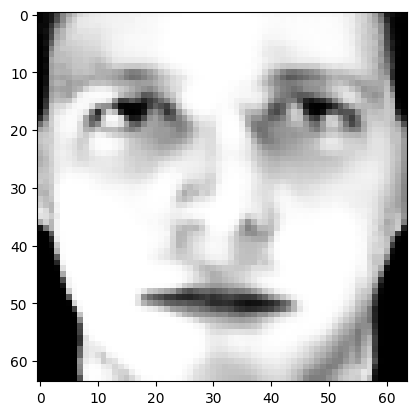

Epoch 31 : 


100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


loss:  1.589918851852417  l_d:  0.1172463446855545  l_e:  0.1172463446855545  l_g:  0.1355426162481308
Epoch 32 : 


100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


loss:  1.3562188148498535  l_d:  0.08753730356693268  l_e:  0.08753730356693268  l_g:  0.1181144192814827
Epoch 33 : 


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


loss:  1.4427876472473145  l_d:  0.09292096644639969  l_e:  0.09292097389698029  l_g:  0.12569457292556763
Epoch 34 : 


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


loss:  1.4895761013031006  l_d:  0.08947321772575378  l_e:  0.08947321772575378  l_g:  0.13106295466423035
Epoch 35 : 


100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


loss:  1.9784891605377197  l_d:  0.0894470140337944  l_e:  0.0894470140337944  l_g:  0.1799595057964325
Epoch 36 : 


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


loss:  1.6724598407745361  l_d:  0.13637153804302216  l_e:  0.13637153804302216  l_g:  0.13997167348861694
Epoch 37 : 


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


loss:  1.857069492340088  l_d:  0.11225941777229309  l_e:  0.11225941777229309  l_g:  0.16325506567955017
Epoch 38 : 


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


loss:  1.1093837022781372  l_d:  0.08824463188648224  l_e:  0.08824463188648224  l_g:  0.09328944981098175
Epoch 39 : 


100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


loss:  1.7471706867218018  l_d:  0.08918759226799011  l_e:  0.08918758481740952  l_g:  0.15687954425811768
Epoch 40 : 


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


loss:  1.4901165962219238  l_d:  0.09862617403268814  l_e:  0.09862618148326874  l_g:  0.12928642332553864


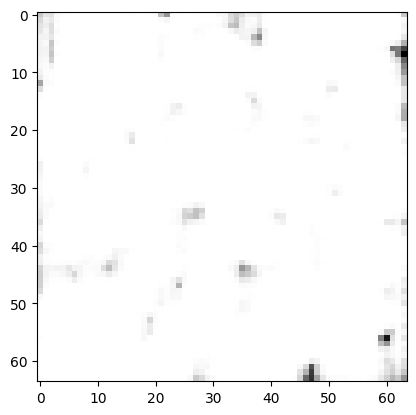

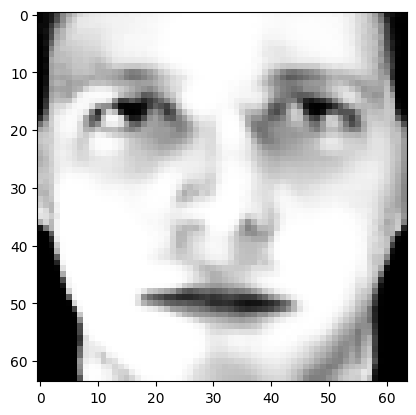

Epoch 41 : 


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


loss:  0.9279788136482239  l_d:  0.09209993481636047  l_e:  0.09209993481636047  l_g:  0.07437789440155029
Epoch 42 : 


100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


loss:  2.2463912963867188  l_d:  0.0882033184170723  l_e:  0.0882033109664917  l_g:  0.20699846744537354
Epoch 43 : 


100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


loss:  1.5493181943893433  l_d:  0.08632604032754898  l_e:  0.08632604032754898  l_g:  0.13766661286354065
Epoch 44 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  1.9184870719909668  l_d:  0.0876626968383789  l_e:  0.0876626968383789  l_g:  0.1743161678314209
Epoch 45 : 


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


loss:  1.2709064483642578  l_d:  0.09159494936466217  l_e:  0.09159494191408157  l_g:  0.10877165198326111
Epoch 46 : 


100%|██████████| 50/50 [00:03<00:00, 12.66it/s]


loss:  1.3485180139541626  l_d:  0.1177225261926651  l_e:  0.1177225261926651  l_g:  0.1113073006272316
Epoch 47 : 


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


loss:  1.3763490915298462  l_d:  0.10970348864793777  l_e:  0.10970348864793777  l_g:  0.11569420993328094
Epoch 48 : 


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


loss:  1.704268217086792  l_d:  0.08527015149593353  l_e:  0.08527015149593353  l_g:  0.15337279438972473
Epoch 49 : 


100%|██████████| 50/50 [00:04<00:00, 12.40it/s]


loss:  1.5894765853881836  l_d:  0.08779977262020111  l_e:  0.08779977262020111  l_g:  0.1413877010345459
Epoch 50 : 


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


loss:  1.0321171283721924  l_d:  0.09887044131755829  l_e:  0.09887044131755829  l_g:  0.08343762159347534


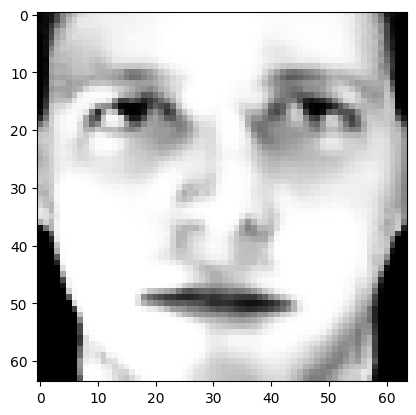

Epoch 51 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  1.1203374862670898  l_d:  0.12934258580207825  l_e:  0.12934258580207825  l_g:  0.08616523444652557
Epoch 52 : 


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


loss:  1.8528982400894165  l_d:  0.10435493290424347  l_e:  0.10435492545366287  l_g:  0.16441884636878967
Epoch 53 : 


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


loss:  1.6816208362579346  l_d:  0.08970578759908676  l_e:  0.08970579504966736  l_g:  0.15022093057632446
Epoch 54 : 


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


loss:  1.8079767227172852  l_d:  0.11211442947387695  l_e:  0.11211442947387695  l_g:  0.15837478637695312
Epoch 55 : 


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


loss:  1.2747893333435059  l_d:  0.09621453285217285  l_e:  0.09621453285217285  l_g:  0.10823602974414825
Epoch 56 : 


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


loss:  1.868889570236206  l_d:  0.17601197957992554  l_e:  0.17601197957992554  l_g:  0.15168656408786774
Epoch 57 : 


100%|██████████| 50/50 [00:03<00:00, 14.82it/s]


loss:  1.3808809518814087  l_d:  0.09024842083454132  l_e:  0.09024841338396072  l_g:  0.12003841251134872
Epoch 58 : 


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


loss:  1.5280370712280273  l_d:  0.11811771243810654  l_e:  0.11811771243810654  l_g:  0.1291801631450653
Epoch 59 : 


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


loss:  1.743009328842163  l_d:  0.09026570618152618  l_e:  0.09026572108268738  l_g:  0.1562477946281433
Epoch 60 : 


100%|██████████| 50/50 [00:03<00:00, 14.24it/s]


loss:  1.5711820125579834  l_d:  0.09655723720788956  l_e:  0.09655723720788956  l_g:  0.1378067433834076


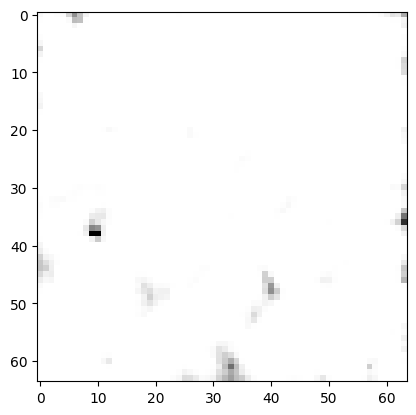

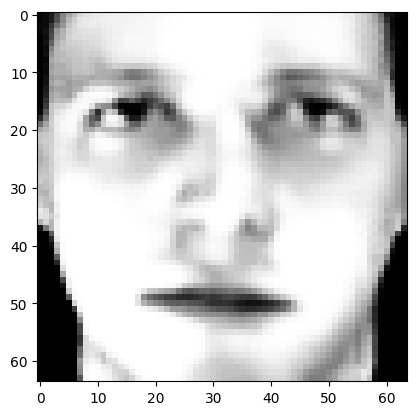

Epoch 61 : 


100%|██████████| 50/50 [00:03<00:00, 12.52it/s]


loss:  1.6592686176300049  l_d:  0.109716035425663  l_e:  0.109716035425663  l_g:  0.1439836472272873
Epoch 62 : 


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


loss:  1.590397596359253  l_d:  0.12526437640190125  l_e:  0.12526437640190125  l_g:  0.13398687541484833
Epoch 63 : 


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


loss:  1.71663236618042  l_d:  0.09348859637975693  l_e:  0.09348860383033752  l_g:  0.1529655158519745
Epoch 64 : 


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


loss:  0.9951993227005005  l_d:  0.10167784988880157  l_e:  0.10167784988880157  l_g:  0.07918436825275421
Epoch 65 : 


100%|██████████| 50/50 [00:03<00:00, 15.02it/s]


loss:  1.7395983934402466  l_d:  0.08708734065294266  l_e:  0.08708734810352325  l_g:  0.15654237568378448
Epoch 66 : 


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


loss:  1.529667854309082  l_d:  0.0946715772151947  l_e:  0.0946715697646141  l_g:  0.1340324729681015
Epoch 67 : 


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


loss:  1.5964891910552979  l_d:  0.08541406691074371  l_e:  0.08541406691074371  l_g:  0.14256611466407776
Epoch 68 : 


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


loss:  1.793813943862915  l_d:  0.09777809679508209  l_e:  0.09777809679508209  l_g:  0.15982577204704285
Epoch 69 : 


100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


loss:  1.8707275390625  l_d:  0.14060983061790466  l_e:  0.14060983061790466  l_g:  0.1589507758617401
Epoch 70 : 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


loss:  1.6113178730010986  l_d:  0.08531367778778076  l_e:  0.08531367778778076  l_g:  0.14406904578208923


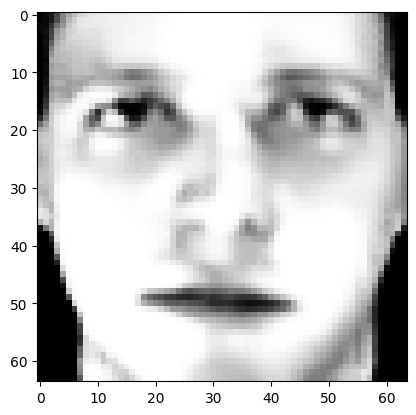

Epoch 71 : 


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


loss:  2.2891547679901123  l_d:  0.10185834765434265  l_e:  0.10185834765434265  l_g:  0.2085438072681427
Epoch 72 : 


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


loss:  1.164090633392334  l_d:  0.08759377151727676  l_e:  0.08759377151727676  l_g:  0.09889030456542969
Epoch 73 : 


100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


loss:  1.5238394737243652  l_d:  0.08605800569057465  l_e:  0.08605800569057465  l_g:  0.13517233729362488
Epoch 74 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  1.2645323276519775  l_d:  0.0837012305855751  l_e:  0.0837012305855751  l_g:  0.10971298813819885
Epoch 75 : 


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


loss:  1.1741334199905396  l_d:  0.09342518448829651  l_e:  0.09342518448829651  l_g:  0.09872830659151077
Epoch 76 : 


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


loss:  1.537626028060913  l_d:  0.09842881560325623  l_e:  0.09842881560325623  l_g:  0.13407683372497559
Epoch 77 : 


100%|██████████| 50/50 [00:03<00:00, 14.14it/s]


loss:  1.4555706977844238  l_d:  0.08163048326969147  l_e:  0.08163048326969147  l_g:  0.12923097610473633
Epoch 78 : 


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


loss:  1.48300039768219  l_d:  0.08695942163467407  l_e:  0.08695942163467407  l_g:  0.13090816140174866
Epoch 79 : 


100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


loss:  0.9567081928253174  l_d:  0.09260374307632446  l_e:  0.09260374307632446  l_g:  0.07715006917715073
Epoch 80 : 


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


loss:  1.5814356803894043  l_d:  0.08584330230951309  l_e:  0.08584330976009369  l_g:  0.14097490906715393


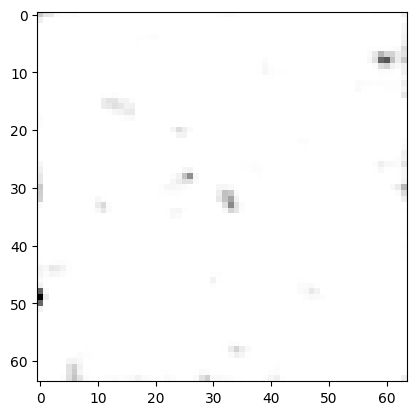

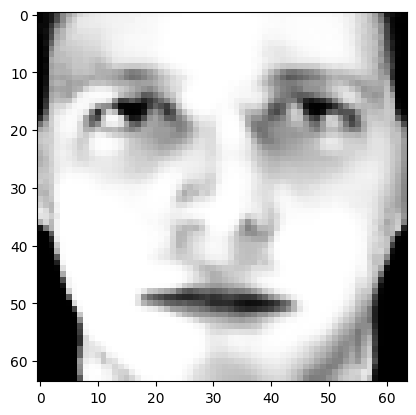

Epoch 81 : 


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


loss:  1.8790017366409302  l_d:  0.11758451163768768  l_e:  0.11758450418710709  l_g:  0.16438326239585876
Epoch 82 : 


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


loss:  1.369653582572937  l_d:  0.09613227844238281  l_e:  0.09613227099180222  l_g:  0.11773890256881714
Epoch 83 : 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


loss:  1.3749229907989502  l_d:  0.08783972263336182  l_e:  0.08783972263336182  l_g:  0.11992435902357101
Epoch 84 : 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


loss:  1.3736448287963867  l_d:  0.08674531430006027  l_e:  0.08674532175064087  l_g:  0.12001542001962662
Epoch 85 : 


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


loss:  1.6949825286865234  l_d:  0.11148027330636978  l_e:  0.11148027330636978  l_g:  0.14720219373703003
Epoch 86 : 


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


loss:  1.641692042350769  l_d:  0.08845877647399902  l_e:  0.08845877647399902  l_g:  0.14647744596004486
Epoch 87 : 


100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


loss:  1.8144510984420776  l_d:  0.09023417532444  l_e:  0.09023417532444  l_g:  0.16339828073978424
Epoch 88 : 


100%|██████████| 50/50 [00:03<00:00, 12.75it/s]


loss:  1.6572017669677734  l_d:  0.08399713039398193  l_e:  0.08399712294340134  l_g:  0.14892074465751648
Epoch 89 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  1.1017204523086548  l_d:  0.09124241769313812  l_e:  0.09124241769313812  l_g:  0.09192356467247009
Epoch 90 : 


100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


loss:  1.5182173252105713  l_d:  0.08847888559103012  l_e:  0.08847889304161072  l_g:  0.1341259628534317


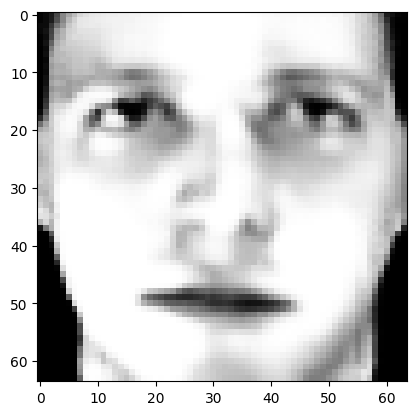

Epoch 91 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  1.7182536125183105  l_d:  0.14720085263252258  l_e:  0.14720085263252258  l_g:  0.14238519966602325
Epoch 92 : 


100%|██████████| 50/50 [00:03<00:00, 12.66it/s]


loss:  1.7903690338134766  l_d:  0.08902338147163391  l_e:  0.08902338147163391  l_g:  0.16123221814632416
Epoch 93 : 


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


loss:  2.3807473182678223  l_d:  0.09507473558187485  l_e:  0.09507473558187485  l_g:  0.2190597802400589
Epoch 94 : 


100%|██████████| 50/50 [00:03<00:00, 12.56it/s]


loss:  1.7043081521987915  l_d:  0.0891009122133255  l_e:  0.0891009122133255  l_g:  0.1526106297969818
Epoch 95 : 


100%|██████████| 50/50 [00:03<00:00, 15.94it/s]


loss:  1.2724182605743408  l_d:  0.19804362952709198  l_e:  0.19804364442825317  l_g:  0.08763310313224792
Epoch 96 : 


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


loss:  1.6139568090438843  l_d:  0.0886649489402771  l_e:  0.0886649489402771  l_g:  0.143662691116333
Epoch 97 : 


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


loss:  1.408858299255371  l_d:  0.08678935468196869  l_e:  0.08678935468196869  l_g:  0.12352795153856277
Epoch 98 : 


100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


loss:  2.6051440238952637  l_d:  0.10418621450662613  l_e:  0.10418621450662613  l_g:  0.23967716097831726
Epoch 99 : 


100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


loss:  1.477003574371338  l_d:  0.08591314405202866  l_e:  0.08591315150260925  l_g:  0.13051772117614746
Epoch 100 : 


100%|██████████| 50/50 [00:04<00:00, 11.64it/s]


loss:  1.412630319595337  l_d:  0.09513988345861435  l_e:  0.09513987600803375  l_g:  0.12223505973815918


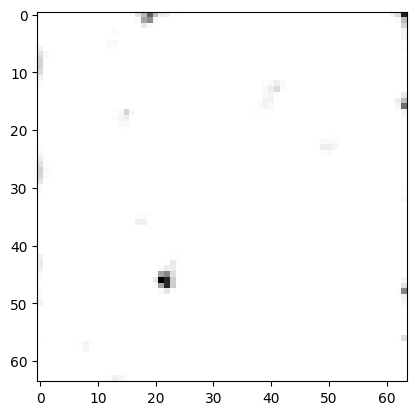

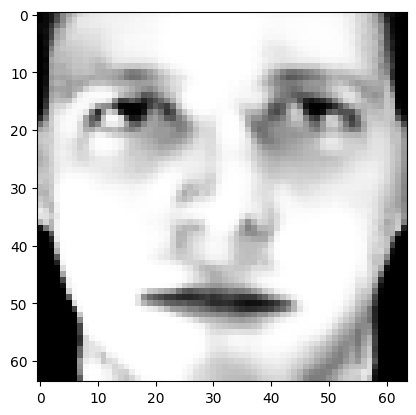

Epoch 101 : 


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


loss:  1.8699493408203125  l_d:  0.1259123980998993  l_e:  0.1259123980998993  l_g:  0.1618124544620514
Epoch 102 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  2.0588784217834473  l_d:  0.08742076903581619  l_e:  0.0874207615852356  l_g:  0.18840369582176208
Epoch 103 : 


100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


loss:  2.2254157066345215  l_d:  0.11152733862400055  l_e:  0.11152733862400055  l_g:  0.20023611187934875
Epoch 104 : 


100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


loss:  2.1146862506866455  l_d:  0.11993598937988281  l_e:  0.119936004281044  l_g:  0.18748141825199127
Epoch 105 : 


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


loss:  2.021557331085205  l_d:  0.0925825983285904  l_e:  0.0925825983285904  l_g:  0.18363921344280243
Epoch 106 : 


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


loss:  1.5547454357147217  l_d:  0.11117132753133774  l_e:  0.11117133498191833  l_g:  0.13324028253555298
Epoch 107 : 


100%|██████████| 50/50 [00:03<00:00, 14.20it/s]


loss:  2.1044158935546875  l_d:  0.1409205198287964  l_e:  0.1409205198287964  l_g:  0.18225747346878052
Epoch 108 : 


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


loss:  1.7046363353729248  l_d:  0.1044226586818695  l_e:  0.1044226586818695  l_g:  0.14957910776138306
Epoch 109 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  1.700313925743103  l_d:  0.10240490734577179  l_e:  0.10240489989519119  l_g:  0.1495504081249237
Epoch 110 : 


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


loss:  1.3225058317184448  l_d:  0.08731645345687866  l_e:  0.08731645345687866  l_g:  0.11478729546070099


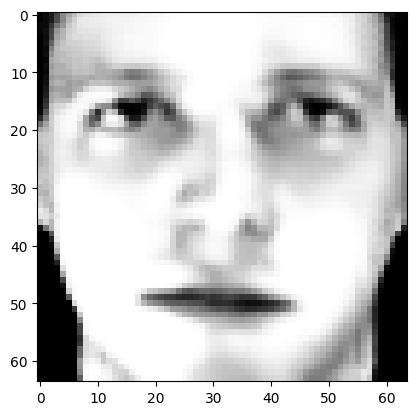

Epoch 111 : 


100%|██████████| 50/50 [00:03<00:00, 14.79it/s]


loss:  1.4406013488769531  l_d:  0.20072612166404724  l_e:  0.20072612166404724  l_g:  0.10391491651535034
Epoch 112 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.9669914245605469  l_d:  0.19521966576576233  l_e:  0.19521966576576233  l_g:  0.15765520930290222
Epoch 113 : 


100%|██████████| 50/50 [00:03<00:00, 13.35it/s]


loss:  1.6794300079345703  l_d:  0.10650648921728134  l_e:  0.10650648921728134  l_g:  0.14664170145988464
Epoch 114 : 


100%|██████████| 50/50 [00:03<00:00, 12.82it/s]


loss:  1.3624275922775269  l_d:  0.08737602084875107  l_e:  0.08737602084875107  l_g:  0.11876755952835083
Epoch 115 : 


100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


loss:  1.423217535018921  l_d:  0.08388102799654007  l_e:  0.08388102799654007  l_g:  0.12554554641246796
Epoch 116 : 


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


loss:  2.576488971710205  l_d:  0.08485430479049683  l_e:  0.08485430479049683  l_g:  0.24067802727222443
Epoch 117 : 


100%|██████████| 50/50 [00:03<00:00, 14.30it/s]


loss:  1.9255067110061646  l_d:  0.08950169384479523  l_e:  0.08950170129537582  l_g:  0.17465034127235413
Epoch 118 : 


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


loss:  1.7339411973953247  l_d:  0.0860322043299675  l_e:  0.0860322043299675  l_g:  0.15618768334388733
Epoch 119 : 


100%|██████████| 50/50 [00:03<00:00, 15.15it/s]


loss:  1.890495777130127  l_d:  0.08556321263313293  l_e:  0.08556321263313293  l_g:  0.17193694412708282
Epoch 120 : 


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


loss:  1.7412269115447998  l_d:  0.08737590909004211  l_e:  0.08737590909004211  l_g:  0.15664750337600708


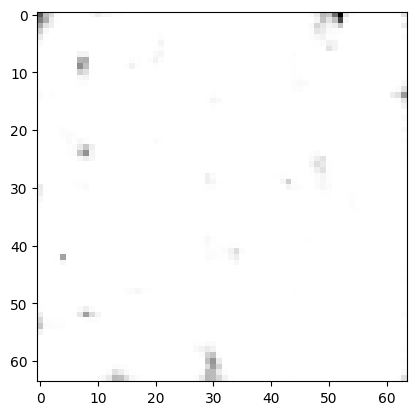

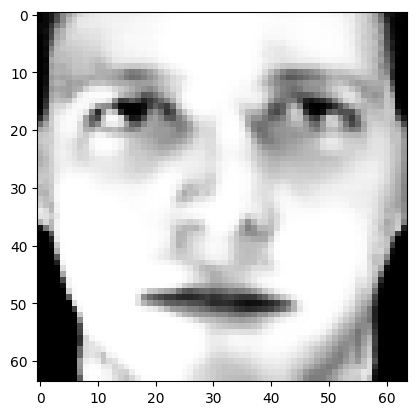

Epoch 121 : 


100%|██████████| 50/50 [00:03<00:00, 12.89it/s]


loss:  1.3741304874420166  l_d:  0.08521624654531479  l_e:  0.08521625399589539  l_g:  0.1203697919845581
Epoch 122 : 


100%|██████████| 50/50 [00:03<00:00, 13.25it/s]


loss:  1.404327630996704  l_d:  0.10358628630638123  l_e:  0.10358628630638123  l_g:  0.11971551179885864
Epoch 123 : 


100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


loss:  1.4494730234146118  l_d:  0.11188064515590668  l_e:  0.11188064515590668  l_g:  0.12257117033004761
Epoch 124 : 


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


loss:  1.3912851810455322  l_d:  0.0992986187338829  l_e:  0.0992986187338829  l_g:  0.11926880478858948
Epoch 125 : 


100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


loss:  1.3743716478347778  l_d:  0.08895163983106613  l_e:  0.08895163983106613  l_g:  0.1196468323469162
Epoch 126 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.517565131187439  l_d:  0.08704488724470139  l_e:  0.08704488724470139  l_g:  0.13434752821922302
Epoch 127 : 


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


loss:  0.953609049320221  l_d:  0.09062603116035461  l_e:  0.09062603116035461  l_g:  0.07723569869995117
Epoch 128 : 


100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


loss:  1.654022455215454  l_d:  0.10865548253059387  l_e:  0.10865548253059387  l_g:  0.1436711549758911
Epoch 129 : 


100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


loss:  1.4540766477584839  l_d:  0.08419223129749298  l_e:  0.08419222384691238  l_g:  0.12856921553611755
Epoch 130 : 


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


loss:  2.077587842941284  l_d:  0.08679498732089996  l_e:  0.08679498732089996  l_g:  0.19039978086948395


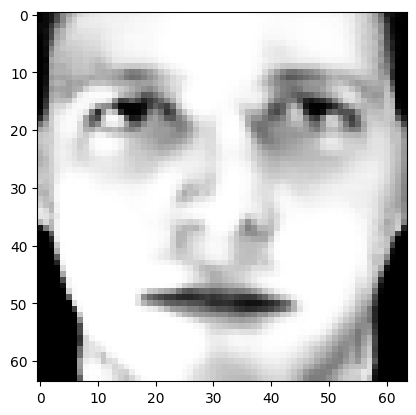

Epoch 131 : 


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


loss:  1.5031702518463135  l_d:  0.08572255074977875  l_e:  0.08572255820035934  l_g:  0.13317251205444336
Epoch 132 : 


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


loss:  2.146263360977173  l_d:  0.11900858581066132  l_e:  0.11900858581066132  l_g:  0.19082462787628174
Epoch 133 : 


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


loss:  2.070350408554077  l_d:  0.10692954063415527  l_e:  0.10692953318357468  l_g:  0.18564912676811218
Epoch 134 : 


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


loss:  1.3816022872924805  l_d:  0.09009229391813278  l_e:  0.09009230136871338  l_g:  0.12014177441596985
Epoch 135 : 


100%|██████████| 50/50 [00:03<00:00, 12.63it/s]


loss:  1.3373101949691772  l_d:  0.08376987278461456  l_e:  0.08376987278461456  l_g:  0.11697705090045929
Epoch 136 : 


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]


loss:  1.4276503324508667  l_d:  0.0888151004910469  l_e:  0.0888151004910469  l_g:  0.12500201165676117
Epoch 137 : 


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


loss:  1.2854379415512085  l_d:  0.09095056354999542  l_e:  0.09095057100057602  l_g:  0.11035367846488953
Epoch 138 : 


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


loss:  1.6029139757156372  l_d:  0.08849836140871048  l_e:  0.08849835395812988  l_g:  0.14259172976016998
Epoch 139 : 


100%|██████████| 50/50 [00:03<00:00, 15.93it/s]


loss:  2.235605001449585  l_d:  0.09795109927654266  l_e:  0.09795109927654266  l_g:  0.2039702832698822
Epoch 140 : 


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


loss:  1.7653260231018066  l_d:  0.09358622133731842  l_e:  0.09358622133731842  l_g:  0.1578153669834137


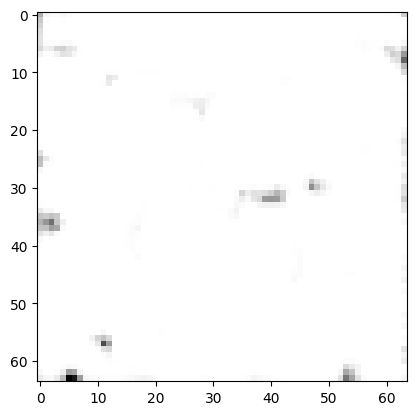

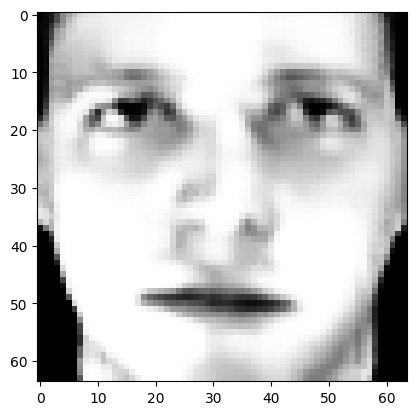

Epoch 141 : 


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


loss:  1.680742621421814  l_d:  0.11250324547290802  l_e:  0.11250324547290802  l_g:  0.14557361602783203
Epoch 142 : 


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


loss:  1.4373128414154053  l_d:  0.0921606719493866  l_e:  0.0921606719493866  l_g:  0.12529915571212769
Epoch 143 : 


100%|██████████| 50/50 [00:04<00:00, 12.42it/s]


loss:  1.6845377683639526  l_d:  0.08708982169628143  l_e:  0.08708982169628143  l_g:  0.15103581547737122
Epoch 144 : 


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


loss:  1.3053715229034424  l_d:  0.0866384208202362  l_e:  0.0866384208202362  l_g:  0.11320945620536804
Epoch 145 : 


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


loss:  1.321969747543335  l_d:  0.12577401101589203  l_e:  0.12577401101589203  l_g:  0.10704216361045837
Epoch 146 : 


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


loss:  0.9906345009803772  l_d:  0.08427361398935318  l_e:  0.08427361398935318  l_g:  0.08220873028039932
Epoch 147 : 


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


loss:  1.4499292373657227  l_d:  0.08545564115047455  l_e:  0.08545563369989395  l_g:  0.12790179252624512
Epoch 148 : 


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


loss:  1.6173609495162964  l_d:  0.08905740082263947  l_e:  0.08905740082263947  l_g:  0.14392462372779846
Epoch 149 : 


100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


loss:  1.3780124187469482  l_d:  0.08359043300151825  l_e:  0.08359043300151825  l_g:  0.12108315527439117
Epoch 150 : 


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


loss:  1.4344468116760254  l_d:  0.09702184796333313  l_e:  0.09702184796333313  l_g:  0.12404031306505203


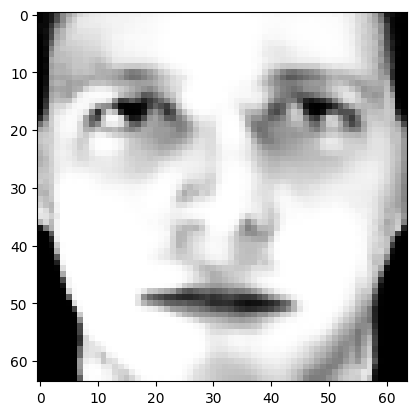

Epoch 151 : 


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


loss:  1.6907716989517212  l_d:  0.08964772522449493  l_e:  0.08964771777391434  l_g:  0.15114763379096985
Epoch 152 : 


100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


loss:  1.1619906425476074  l_d:  0.08438947051763535  l_e:  0.08438947051763535  l_g:  0.09932117164134979
Epoch 153 : 


100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


loss:  1.0710091590881348  l_d:  0.12215892225503922  l_e:  0.12215892225503922  l_g:  0.08266913145780563
Epoch 154 : 


100%|██████████| 50/50 [00:02<00:00, 17.91it/s]


loss:  1.407820224761963  l_d:  0.09307518601417542  l_e:  0.09307518601417542  l_g:  0.12216699123382568
Epoch 155 : 


100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


loss:  1.068284034729004  l_d:  0.08273138105869293  l_e:  0.08273138105869293  l_g:  0.0902821272611618
Epoch 156 : 


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


loss:  1.4395250082015991  l_d:  0.14437513053417206  l_e:  0.14437513053417206  l_g:  0.11507747322320938
Epoch 157 : 


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


loss:  1.0812368392944336  l_d:  0.08532852679491043  l_e:  0.08532851934432983  l_g:  0.09105798602104187
Epoch 158 : 


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


loss:  1.1195664405822754  l_d:  0.09196959435939789  l_e:  0.09196959435939789  l_g:  0.09356272965669632
Epoch 159 : 


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


loss:  1.8373208045959473  l_d:  0.08626724779605865  l_e:  0.08626724034547806  l_g:  0.16647863388061523
Epoch 160 : 


100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


loss:  1.1973450183868408  l_d:  0.10768041014671326  l_e:  0.10768041014671326  l_g:  0.09819842129945755


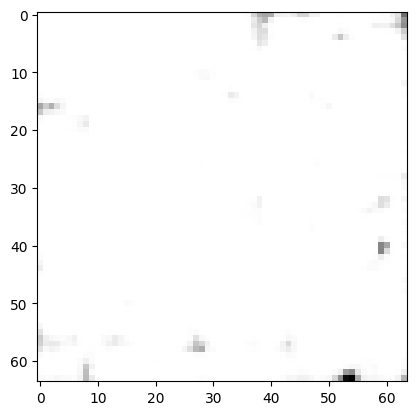

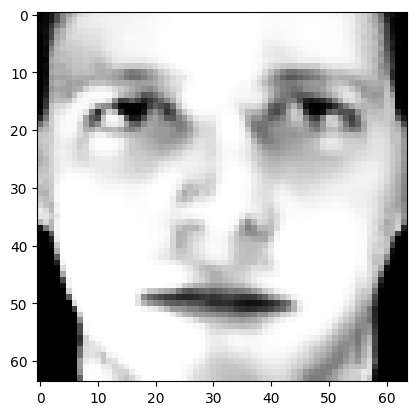

Epoch 161 : 


100%|██████████| 50/50 [00:02<00:00, 16.82it/s]


loss:  1.9241796731948853  l_d:  0.08503402024507523  l_e:  0.08503401279449463  l_g:  0.1754111647605896
Epoch 162 : 


100%|██████████| 50/50 [00:02<00:00, 18.61it/s]


loss:  1.668966293334961  l_d:  0.08170439302921295  l_e:  0.08170438557863235  l_g:  0.15055575966835022
Epoch 163 : 


100%|██████████| 50/50 [00:02<00:00, 16.75it/s]


loss:  1.7952516078948975  l_d:  0.1300874799489975  l_e:  0.1300874650478363  l_g:  0.15350766479969025
Epoch 164 : 


100%|██████████| 50/50 [00:02<00:00, 16.83it/s]


loss:  1.936336874961853  l_d:  0.0868501141667366  l_e:  0.0868501216173172  l_g:  0.17626366019248962
Epoch 165 : 


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


loss:  1.484928011894226  l_d:  0.10394378006458282  l_e:  0.10394378006458282  l_g:  0.12770405411720276
Epoch 166 : 


100%|██████████| 50/50 [00:02<00:00, 17.85it/s]


loss:  2.0693418979644775  l_d:  0.08637651801109314  l_e:  0.08637651801109314  l_g:  0.18965888023376465
Epoch 167 : 


100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


loss:  1.437653660774231  l_d:  0.08767659962177277  l_e:  0.08767659962177277  l_g:  0.12623004615306854
Epoch 168 : 


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


loss:  1.6167516708374023  l_d:  0.1272772252559662  l_e:  0.1272772252559662  l_g:  0.13621971011161804
Epoch 169 : 


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


loss:  2.164738655090332  l_d:  0.14057274162769318  l_e:  0.14057272672653198  l_g:  0.1883593201637268
Epoch 170 : 


100%|██████████| 50/50 [00:02<00:00, 17.36it/s]


loss:  1.6398415565490723  l_d:  0.14083245396614075  l_e:  0.14083245396614075  l_g:  0.13581766188144684


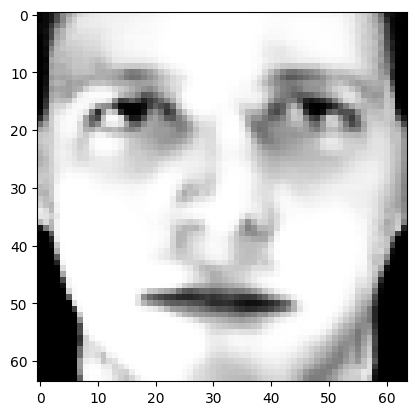

Epoch 171 : 


100%|██████████| 50/50 [00:02<00:00, 18.47it/s]


loss:  1.3608455657958984  l_d:  0.08414985239505768  l_e:  0.08414985239505768  l_g:  0.11925458908081055
Epoch 172 : 


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


loss:  1.0358706712722778  l_d:  0.09411849826574326  l_e:  0.09411849826574326  l_g:  0.08476337045431137
Epoch 173 : 


100%|██████████| 50/50 [00:02<00:00, 17.91it/s]


loss:  1.767844319343567  l_d:  0.08697064220905304  l_e:  0.08697063475847244  l_g:  0.15939030051231384
Epoch 174 : 


100%|██████████| 50/50 [00:02<00:00, 17.18it/s]


loss:  1.1429393291473389  l_d:  0.08640105277299881  l_e:  0.0864010602235794  l_g:  0.09701371937990189
Epoch 175 : 


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


loss:  1.8724725246429443  l_d:  0.09758390486240387  l_e:  0.09758390486240387  l_g:  0.16773048043251038
Epoch 176 : 


100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


loss:  1.4323879480361938  l_d:  0.09869509190320969  l_e:  0.09869509190320969  l_g:  0.1234997808933258
Epoch 177 : 


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


loss:  2.1222939491271973  l_d:  0.15947479009628296  l_e:  0.15947479009628296  l_g:  0.1803344488143921
Epoch 178 : 


100%|██████████| 50/50 [00:03<00:00, 15.89it/s]


loss:  2.1387603282928467  l_d:  0.09310568869113922  l_e:  0.09310568869113922  l_g:  0.19525489211082458
Epoch 179 : 


100%|██████████| 50/50 [00:02<00:00, 18.88it/s]


loss:  1.563677430152893  l_d:  0.0862879827618599  l_e:  0.0862879827618599  l_g:  0.13911014795303345
Epoch 180 : 


100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


loss:  1.6109116077423096  l_d:  0.1647142469882965  l_e:  0.1647142469882965  l_g:  0.12814831733703613


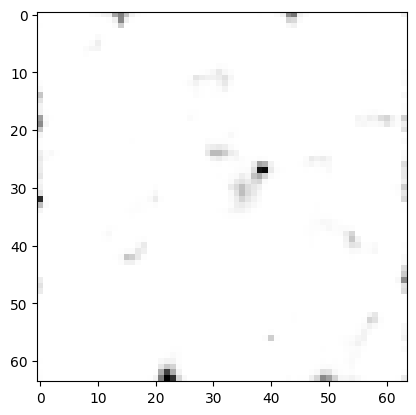

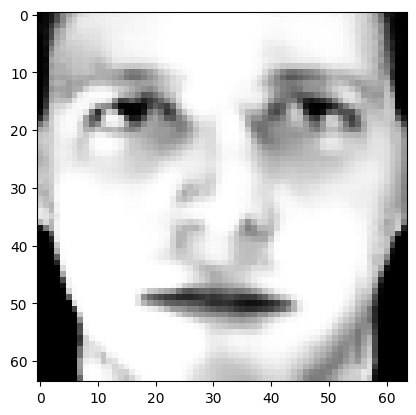

Epoch 181 : 


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


loss:  1.4201539754867554  l_d:  0.0885351225733757  l_e:  0.0885351225733757  l_g:  0.12430837750434875
Epoch 182 : 


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


loss:  2.232722759246826  l_d:  0.09533900022506714  l_e:  0.09533898532390594  l_g:  0.2042044848203659
Epoch 183 : 


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


loss:  1.051114797592163  l_d:  0.09457188844680786  l_e:  0.09457189589738846  l_g:  0.08619710803031921
Epoch 184 : 


100%|██████████| 50/50 [00:02<00:00, 19.03it/s]


loss:  2.0376710891723633  l_d:  0.08604787290096283  l_e:  0.08604787290096283  l_g:  0.18655754625797272
Epoch 185 : 


100%|██████████| 50/50 [00:02<00:00, 18.54it/s]


loss:  2.3099594116210938  l_d:  0.08672012388706207  l_e:  0.08672012388706207  l_g:  0.21365191042423248
Epoch 186 : 


100%|██████████| 50/50 [00:03<00:00, 16.11it/s]


loss:  1.6573858261108398  l_d:  0.09301900863647461  l_e:  0.09301900863647461  l_g:  0.14713478088378906
Epoch 187 : 


100%|██████████| 50/50 [00:02<00:00, 17.28it/s]


loss:  1.795705795288086  l_d:  0.15128321945667267  l_e:  0.15128323435783386  l_g:  0.14931394159793854
Epoch 188 : 


100%|██████████| 50/50 [00:03<00:00, 16.09it/s]


loss:  1.3140959739685059  l_d:  0.08518922328948975  l_e:  0.08518922328948975  l_g:  0.11437174677848816
Epoch 189 : 


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


loss:  2.002197504043579  l_d:  0.08668677508831024  l_e:  0.08668677508831024  l_g:  0.1828823983669281
Epoch 190 : 


100%|██████████| 50/50 [00:03<00:00, 16.21it/s]


loss:  1.7882153987884521  l_d:  0.08689364790916443  l_e:  0.08689364790916443  l_g:  0.1614428162574768


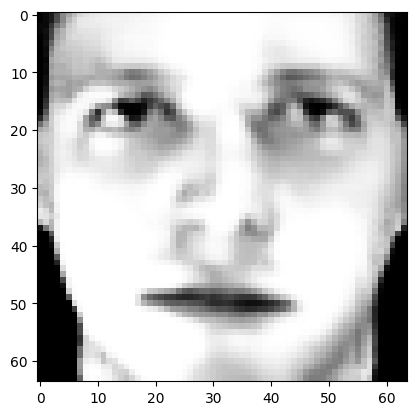

Epoch 191 : 


100%|██████████| 50/50 [00:02<00:00, 17.28it/s]


loss:  1.3102062940597534  l_d:  0.09780137240886688  l_e:  0.09780137240886688  l_g:  0.1114603579044342
Epoch 192 : 


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


loss:  1.8940991163253784  l_d:  0.10860831290483475  l_e:  0.10860831290483475  l_g:  0.167688250541687
Epoch 193 : 


100%|██████████| 50/50 [00:02<00:00, 18.66it/s]


loss:  1.1898434162139893  l_d:  0.08524265885353088  l_e:  0.08524265140295029  l_g:  0.10193581879138947
Epoch 194 : 


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


loss:  1.710413932800293  l_d:  0.10044744610786438  l_e:  0.10044743865728378  l_g:  0.15095190703868866
Epoch 195 : 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


loss:  1.5582246780395508  l_d:  0.12246164679527283  l_e:  0.12246163934469223  l_g:  0.13133014738559723
Epoch 196 : 


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


loss:  1.7819017171859741  l_d:  0.0850030928850174  l_e:  0.0850030928850174  l_g:  0.16118955612182617
Epoch 197 : 


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


loss:  1.5833077430725098  l_d:  0.08013916015625  l_e:  0.08013916015625  l_g:  0.14230294525623322
Epoch 198 : 


100%|██████████| 50/50 [00:03<00:00, 15.49it/s]


loss:  1.9359536170959473  l_d:  0.09956683218479156  l_e:  0.09956683218479156  l_g:  0.17368200421333313
Epoch 199 : 


100%|██████████| 50/50 [00:02<00:00, 18.45it/s]


loss:  1.7688350677490234  l_d:  0.08548937737941742  l_e:  0.08548937737941742  l_g:  0.15978562831878662


In [12]:
train_d2c(200, 0.0005, 0.99, 0.0000, 10)